In [54]:
#!/usr/bin/env python
# coding: utf-8

"""
Knowledge Distillation Training for XiaoNet
Teacher: PhaseNet (from STEAD)
Student: XiaoNet (v5b)
Dataset: OKLA regional seismic data
"""

# Standard library
import os
import sys
import json
import random
from pathlib import Path

# Scientific computing
import numpy as np
import pandas as pd
from scipy import signal

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Seismology & SeisBench
import obspy
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

# Progress bars
from tqdm.notebook import tqdm

# Add parent directory to path for importing local modules
sys.path.append(str(Path.cwd().parent))

# XiaoNet modules
from models.xn_xiao_net_v2 import XiaoNet as XiaoNetV2
from models.xn_xiao_net_v3 import XiaoNet as XiaoNetV3
from models.xn_xiao_net_v4 import XiaoNetFast as XiaoNetV4
from models.xn_xiao_net_v5 import XiaoNetEdge as XiaoNetV5
from models.xn_xiao_net_v5a import XiaoNetV5A as XiaoNetV5A
from models.xn_xiao_net_v5b import XiaoNetV5B as XiaoNetV5B

print("✓ All packages loaded successfully!")

✓ All packages loaded successfully!


In [55]:
class EarlyStopping:
    """
    Early stopping to halt training when validation loss stops improving.
    
    Args:
        patience: Epochs to wait before stopping
        min_delta: Minimum improvement threshold (positive value)
        checkpoint_dir: Directory for checkpoints
        verbose: Print progress messages
    """
    
    def __init__(self, patience=10, min_delta=0.0, checkpoint_dir='checkpoints/', verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        self.verbose = verbose
        
        self.counter = 0
        self.best_loss = None  # Store actual loss for clarity
        self.early_stop = False
        self.checkpoint_path = self.checkpoint_dir / 'best_model.pth'
    
    def __call__(self, val_loss, model, epoch):
        """
        Check if training should stop early.
        
        Args:
            val_loss: Current validation loss (lower is better)
            model: Model to save if improvement found
            epoch: Current epoch number
        """
        # First epoch - initialize
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model, epoch, val_loss)
            return
        
        # Check for improvement (val_loss decreased by at least min_delta)
        if val_loss < self.best_loss - self.min_delta:
            # Improvement found
            self.best_loss = val_loss
            self.save_checkpoint(model, epoch, val_loss)
            self.counter = 0
        else:
            # No improvement
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience} (best loss: {self.best_loss:.6f})')
            if self.counter >= self.patience:
                self.early_stop = True
    
    def save_checkpoint(self, model, epoch, val_loss):
        """Save model checkpoint."""
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'val_loss': val_loss,
            'best_loss': self.best_loss
        }, self.checkpoint_path)
        if self.verbose:
            print(f'✓ Validation loss improved: {val_loss:.6f}. Saved to {self.checkpoint_path}')

In [56]:
# Define utility functions
def set_seed(seed):
    """Set random seed for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [57]:
def setup_device(device_type='cuda'):
    """Setup compute device (CUDA if available, else CPU)."""
    if device_type == 'cuda' and torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

In [58]:
# Set random seed for reproducibility
SEED = 0
set_seed(SEED)

# Set device
device = setup_device('cuda')
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cpu
CUDA available: False


In [59]:
# Load configuration from config.json
config_path = Path.cwd().parent / "config.json"

if not config_path.exists():
    raise FileNotFoundError(f"Config file not found: {config_path}")

with open(config_path, "r") as f:
    config = json.load(f)

print(f"Loaded configuration from: {config_path}")
print(json.dumps(config, indent=2))

Loaded configuration from: /Users/hongyuxiao/Hongyu_File/xiao_net/config.json
{
  "peak_detection": {
    "sampling_rate": 100,
    "height": 0.5,
    "distance": 100
  },
  "data": {
    "dataset_name": "OKLA_1Mil_120s_Ver_3",
    "sampling_rate": 100,
    "window_len": 3001,
    "samples_before": 3000,
    "windowlen_large": 6000,
    "sample_fraction": 0.005
  },
  "data_filter": {
    "min_magnitude": -1.0,
    "max_magnitude": 10.0
  },
  "training": {
    "batch_size": 64,
    "num_workers": 10,
    "learning_rate": 0.01,
    "epochs": 50,
    "patience": 5,
    "loss_weights": [
      0.01,
      0.4,
      0.59
    ],
    "optimization": {
      "mixed_precision": true,
      "gradient_accumulation_steps": 1,
      "pin_memory": true,
      "prefetch_factor": 2,
      "persistent_workers": true
    }
  },
  "device": {
    "use_cuda": true,
    "device_id": 0
  }
}


In [60]:
print("\nInitializing XiaoNet V5B student model...")
model = XiaoNetV5B(window_len=3001, in_channels=3, num_phases=3, base_channels=8)
model.to(device)
model.train()  # Set to training mode for student

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ XiaoNet V5B student loaded successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model on device: {next(model.parameters()).device}")


Initializing XiaoNet V5B student model...

✓ XiaoNet V5B student loaded successfully!
Total parameters: 20,208
Trainable parameters: 20,208
Model on device: cpu


In [61]:
print("\nLoading PhaseNet teacher model from checkpoint...")

# Load teacher model from best checkpoint
teacher_checkpoint_path = Path.cwd().parent / "checkpoints" / "PNet_best_model.pth"

if not teacher_checkpoint_path.exists():
    raise FileNotFoundError(f"Teacher checkpoint not found: {teacher_checkpoint_path}")

# Initialize PhaseNet architecture
teacher_model = sbm.PhaseNet(in_channels=3, classes=3, phases="NPS")

# Load trained weights from checkpoint
checkpoint = torch.load(teacher_checkpoint_path, map_location=device)
if 'model_state_dict' in checkpoint:
    teacher_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded from epoch: {checkpoint.get('epoch', 'unknown')}")
    print(f"Checkpoint val_loss: {checkpoint.get('val_loss', 'unknown'):.6f}")
else:
    teacher_model.load_state_dict(checkpoint)

teacher_model.to(device)
teacher_model.eval()  # Teacher is always in eval mode

# Freeze teacher parameters
for param in teacher_model.parameters():
    param.requires_grad = False

# Count teacher parameters
teacher_total_params = sum(p.numel() for p in teacher_model.parameters())

print(f"\n✓ PhaseNet teacher loaded successfully from {teacher_checkpoint_path.name}!")
print(f"Teacher parameters: {teacher_total_params:,}")
print(f"Teacher on device: {next(teacher_model.parameters()).device}")


Loading PhaseNet teacher model from checkpoint...
Loaded from epoch: 27
Checkpoint val_loss: 0.057418

✓ PhaseNet teacher loaded successfully from PNet_best_model.pth!
Teacher parameters: 268,443
Teacher on device: cpu


In [62]:
# Load OKLA dataset
print("Loading OKLA regional seismic dataset...")
data = sbd.OKLA_1Mil_120s_Ver_3(sampling_rate=100, force=True, component_order="ENZ")

# Optional: Use subset for faster experimentation
sample_fraction = config.get('data', {}).get('sample_fraction', 0.1)
if sample_fraction < 1.0:
    print(f"Sampling {sample_fraction*100}% of data for faster training...")
    # Create a random mask for sampling
    mask = np.random.random(len(data)) < sample_fraction
    data.filter(mask, inplace=True)
    print(f"Sampled dataset size: {len(data):,}")

# Split into train/dev/test
train, dev, test = data.train_dev_test()

print(f"\n✓ Dataset loaded successfully!")
print(f"Training samples: {len(train):,}")
print(f"Validation samples: {len(dev):,}")
print(f"Test samples: {len(test):,}")
print(f"Total samples: {len(data):,}")

Loading OKLA regional seismic dataset...
Sampling 0.5% of data for faster training...
Sampled dataset size: 5,632

✓ Dataset loaded successfully!
Training samples: 3,959
Validation samples: 834
Test samples: 839
Total samples: 5,632


In [63]:
# Magnitude filtering (with defaults)
min_magnitude = config.get('data_filter', {}).get('min_magnitude', 1.0)
max_magnitude = config.get('data_filter', {}).get('max_magnitude', 2.0)

print(f"Applying magnitude filters: {min_magnitude} < M < {max_magnitude}")

try:
    # Filter events with magnitude above the minimum
    print(f"✓ [Data Filter]: Start - magnitude > {min_magnitude}")
    mask = data.metadata["source_magnitude"] > min_magnitude
    data.filter(mask, inplace=True)
    print(f"✓ [Data Filter]: Applied - magnitude > {min_magnitude}, remaining samples: {len(data):,}")
except Exception as exc:
    print("✗ [Data Filter]: Error - Failed to apply minimum magnitude filter.")
    print(f"  Details: {exc}")
    raise

try:
    # Filter events with magnitude below the maximum
    print(f"✓ [Data Filter]: Start - magnitude < {max_magnitude}")
    mask = data.metadata["source_magnitude"] < max_magnitude
    data.filter(mask, inplace=True)
    print(f"✓ [Data Filter]: Applied - magnitude < {max_magnitude}, remaining samples: {len(data):,}")
except Exception as exc:
    print("✗ [Data Filter]: Error - Failed to apply maximum magnitude filter.")
    print(f"  Details: {exc}")
    raise

print(f"\n✓ Magnitude filtering complete: {len(data):,} traces in range [{min_magnitude}, {max_magnitude}]")

Applying magnitude filters: -1.0 < M < 10.0
✓ [Data Filter]: Start - magnitude > -1.0
✓ [Data Filter]: Applied - magnitude > -1.0, remaining samples: 5,631
✓ [Data Filter]: Start - magnitude < 10.0
✓ [Data Filter]: Applied - magnitude < 10.0, remaining samples: 5,631

✓ Magnitude filtering complete: 5,631 traces in range [-1.0, 10.0]


In [64]:
# Dataset summary for training
print("\n" + "=" * 60)
print("DATASET SUMMARY")
print("=" * 60)

# Core sizes
print(f"Total dataset size: {len(data):,}")
print(f"Train size: {len(train):,}")
print(f"Validation size: {len(dev):,}")
print(f"Test size: {len(test):,}")

# Sampling configuration
sampling_rate = config.get('data', {}).get('sampling_rate', 'unknown')
window_len = config.get('data', {}).get('window_len', 'unknown')
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Window length: {window_len} samples")

# Metadata summary (if available)
if hasattr(data, 'metadata') and data.metadata is not None:
    if 'source_magnitude' in data.metadata:
        mags = data.metadata['source_magnitude']
        print(f"Magnitude stats: min={mags.min():.2f}, max={mags.max():.2f}, mean={mags.mean():.2f}")
    print(f"Metadata columns: {list(data.metadata.columns)}")

print("=" * 60)


DATASET SUMMARY
Total dataset size: 5,631
Train size: 3,959
Validation size: 834
Test size: 839
Sampling rate: 100 Hz
Window length: 3001 samples
Magnitude stats: min=-0.92, max=4.88, mean=2.13
Metadata columns: ['index', 'station_network_code', 'station_code', 'trace_channel', 'station_latitude_deg', 'station_longitude_deg', 'station_elevation_m', 'trace_p_arrival_sample', 'trace_p_status', 'trace_p_weight', 'path_p_travel_sec', 'trace_s_arrival_sample', 'trace_s_status', 'trace_s_weight', 'source_id', 'source_origin_time', 'source_origin_uncertainty_sec', 'source_latitude_deg', 'source_longitude_deg', 'source_error_sec', 'source_gap_deg', 'source_horizontal_uncertainty_km', 'source_depth_km', 'source_depth_uncertainty_km', 'source_magnitude', 'source_magnitude_type', 'source_magnitude_author', 'source_mechanism_strike_dip_rake', 'source_distance_deg', 'source_distance_km', 'path_back_azimuth_deg', 'trace_snr_db', 'trace_coda_end_sample', 'trace_start_time', 'trace_category', 'trace_

In [65]:
# Split data into train/dev/test after filtering
train, dev, test = data.train_dev_test()

print("\n✓ Dataset split after filtering")
print(f"Train size: {len(train):,}")
print(f"Validation size: {len(dev):,}")
print(f"Test size: {len(test):,}")

# Split ratios
n_total = len(train) + len(dev) + len(test)
if n_total > 0:
    print(f"Split ratios: train={len(train)/n_total:.2%}, dev={len(dev)/n_total:.2%}, test={len(test)/n_total:.2%}")


✓ Dataset split after filtering
Train size: 3,959
Validation size: 834
Test size: 838
Split ratios: train=70.31%, dev=14.81%, test=14.88%


In [66]:
# Dataset objects (compact summary)
print("\n" + "=" * 60)
print("DATASET OBJECTS")
print("=" * 60)
print(f"Train dataset: {train}")
print(f"Dev dataset:   {dev}")
print(f"Test dataset:  {test}")
print("=" * 60)


DATASET OBJECTS
Train dataset: OKLA_1Mil_120s_Ver_3 - 3959 traces
Dev dataset:   OKLA_1Mil_120s_Ver_3 - 834 traces
Test dataset:  OKLA_1Mil_120s_Ver_3 - 838 traces


In [67]:
# Set up data augmentation

phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

In [68]:
# Create the data generators for training and validation
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

In [69]:
# Define phase lists for labeling
p_phases = [key for key, val in phase_dict.items() if val == "P"]
s_phases = [key for key, val in phase_dict.items() if val == "S"]

train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(sigma=30, dim=0),
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)


In [70]:
# Parameters for peak detection (with defaults)
sampling_rate = config.get('peak_detection', {}).get('sampling_rate', 100)
height = config.get('peak_detection', {}).get('height', 0.5)
distance = config.get('peak_detection', {}).get('distance', 100)

print("\n" + "=" * 60)
print("PEAK DETECTION SETTINGS")
print("=" * 60)
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Height threshold: {height}")
print(f"Minimum peak distance: {distance} samples")
print("=" * 60)


PEAK DETECTION SETTINGS
Sampling rate: 100 Hz
Height threshold: 0.5
Minimum peak distance: 100 samples


In [71]:
# Parameters for peak detection
batch_size = config['training']['batch_size']
num_workers = config['training']['num_workers']
print(f"✓ [DataLoader]: batch_size={batch_size}, num_workers={num_workers}")

✓ [DataLoader]: batch_size=64, num_workers=10


In [72]:
print("\n" + "=" * 60)
print("TRAINING CONFIGURATION SUMMARY")
print("=" * 60)

# Dataset info
print("[Dataset]")
print(f"  Total samples:      {len(data):,}")
print(f"  Train/Validation/Test:     {len(train):,} / {len(dev):,} / {len(test):,}")
print(f"  Sample fraction:    {sample_fraction*100:.1f}%")

# Device
print("\n[Device]")
print(f"  Device:             {device}")

# Training hyperparameters
print("\n[Training]")
print(f"  Batch size:         {batch_size}")
print(f"  Num workers:        {num_workers}")
print(f"  Learning rate:      {config['training']['learning_rate']}")
print(f"  Epochs:             {config['training']['epochs']}")
print(f"  Patience:           {config['training']['patience']}")

# Peak detection
print("\n[Peak Detection]")
print(f"  Sampling rate:      {sampling_rate} Hz")
print(f"  Height threshold:   {height}")
print(f"  Min peak distance:  {distance} samples")

print("=" * 60)
print("Ready to start training!")
print("=" * 60)


TRAINING CONFIGURATION SUMMARY
[Dataset]
  Total samples:      5,631
  Train/Validation/Test:     3,959 / 834 / 838
  Sample fraction:    0.5%

[Device]
  Device:             cpu

[Training]
  Batch size:         64
  Num workers:        10
  Learning rate:      0.01
  Epochs:             50
  Patience:           5

[Peak Detection]
  Sampling rate:      100 Hz
  Height threshold:   0.5
  Min peak distance:  100 samples
Ready to start training!


In [73]:
# Load the data for machine learning

train_loader = DataLoader(train_generator,batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)
val_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)


In [74]:
# Learning rate and number of epochs
learning_rate = config['training']['learning_rate']
epochs = config['training']['epochs']

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("\n" + "=" * 60)
print(f"Optimizer: {optimizer.__class__.__name__}")
print("=" * 60)


Optimizer: Adam


In [75]:
# Define Knowledge Distillation loss function for phase picking
def kd_loss_fn(student_output, teacher_output, ground_truth, alpha=0.5, temperature=1.0, eps=1e-8):
    """
    Knowledge Distillation Loss for phase picking with BALANCED scaling.
    
    Phase picking is NOT classification - each timepoint has independent probabilities
    for P, S, and Noise phases. We distill in probability space, not logit space.
    
    Args:
        student_output: Student model predictions (batch, 3, samples) - probabilities [0,1]
        teacher_output: Teacher model predictions (batch, 3, samples) - probabilities [0,1]
        ground_truth: Ground truth labels (batch, 3, samples) - probabilities [0,1]
        alpha: Weight for hard target loss (0.5 = equal balance)
        temperature: Softening parameter for teacher predictions (1.0 = no softening)
        eps: Small constant for numerical stability
    
    Returns:
        (total_loss, hard_loss, soft_loss)
    """
    # Hard target loss: Binary Cross-Entropy with ground truth
    # Each phase channel is treated independently
    hard_loss = -torch.mean(
        ground_truth * torch.log(student_output + eps) + 
        (1 - ground_truth) * torch.log(1 - student_output + eps)
    )
    
    # Soft target loss: KL divergence in probability space (properly scaled)
    # This measures how different student and teacher probability distributions are
    if temperature == 1.0:
        # KL divergence: D_KL(teacher || student) = sum(teacher * log(teacher/student))
        # This is the "correct" way to distill probabilities (not logits)
        soft_loss = torch.mean(
            teacher_output * torch.log((teacher_output + eps) / (student_output + eps)) +
            (1 - teacher_output) * torch.log((1 - teacher_output + eps) / (1 - student_output + eps))
        )
    else:
        # Apply temperature softening to teacher predictions
        # Soften peaks: teacher_soft = (teacher^(1/T)) / sum(teacher^(1/T))
        teacher_soft = torch.pow(teacher_output + eps, 1.0 / temperature)
        # Normalize per-sample across phase dimension to maintain probability interpretation
        teacher_soft = teacher_soft / (teacher_soft.sum(dim=1, keepdim=True) + eps)
        
        # KL divergence with softened teacher
        soft_loss = torch.mean(
            teacher_soft * torch.log((teacher_soft + eps) / (student_output + eps)) +
            (1 - teacher_soft) * torch.log((1 - teacher_soft + eps) / (1 - student_output + eps))
        )
    
    # CRITICAL: Check loss scales are comparable
    # If soft_loss is 100x smaller than hard_loss, the teacher is being ignored!
    # Combined loss: weighted sum
    total_loss = alpha * hard_loss + (1 - alpha) * soft_loss
    
    return total_loss, hard_loss.detach(), soft_loss.detach()

In [76]:
# Learning rate and number of epochs
learning_rate = config['training']['learning_rate']
epochs = config['training']['epochs']

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("\n" + "=" * 60)
print("OPTIMIZER SETTINGS")
print("=" * 60)
print(f"Optimizer: {optimizer.__class__.__name__}")
print("=" * 60)


OPTIMIZER SETTINGS
Optimizer: Adam


In [77]:
# Early stopping and checkpoint setup
checkpoint_dir = Path.cwd().parent / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)

best_model_path = checkpoint_dir / "best_model.pth"
final_model_path = checkpoint_dir / "final_model.pth"
history_path = checkpoint_dir / "loss_history.json"

patience = config.get('training', {}).get('patience', 5)
min_delta = config.get('training', {}).get('min_delta', 0.0)

early_stopping = EarlyStopping(
    patience=patience,
    min_delta=min_delta,
    checkpoint_dir=checkpoint_dir,
    verbose=True,
)

# Loss history container
history = {
    "train_loss": [],
    "val_loss": []
}

# Helper functions for saving
def save_loss_history(history_dict, path):
    with open(path, "w") as f:
        json.dump(history_dict, f, indent=2)
    print(f"✓ Loss history saved to {path}")


def save_final_model(model, path):
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config
    }, path)
    print(f"✓ Final model saved to {path}")

print("\n" + "=" * 60)
print("EARLY STOPPING & CHECKPOINTS")
print("=" * 60)
print(f"Checkpoint dir: {checkpoint_dir}")
print(f"Best model:     {best_model_path}")
print(f"Final model:    {final_model_path}")
print(f"History file:   {history_path}")
print(f"Patience:       {patience}")
print(f"Min delta:      {min_delta}")
print("=" * 60)


EARLY STOPPING & CHECKPOINTS
Checkpoint dir: /Users/hongyuxiao/Hongyu_File/xiao_net/checkpoints
Best model:     /Users/hongyuxiao/Hongyu_File/xiao_net/checkpoints/best_model.pth
Final model:    /Users/hongyuxiao/Hongyu_File/xiao_net/checkpoints/final_model.pth
History file:   /Users/hongyuxiao/Hongyu_File/xiao_net/checkpoints/loss_history.json
Patience:       5
Min delta:      0.0


In [78]:
# Knowledge Distillation Training Loop
print("\n" + "=" * 60)
print("KNOWLEDGE DISTILLATION TRAINING")
print("=" * 60)

# KD hyperparameters
alpha = 0.3  # 30% ground truth, 70% teacher (adjusted for balanced influence)
temperature = 1.0  # No softening (direct probability matching)

print(f"KD Parameters: alpha={alpha}, temperature={temperature}")
print(f"Loss = {alpha} * BCE(student, ground_truth) + {1-alpha} * KL(student, teacher)")
print("ADJUSTED: Increased teacher weight (70%) since soft_loss scale is ~4x smaller than hard_loss")
print("This should give roughly equal gradient contribution from teacher and ground truth.")
print("=" * 60)

for epoch in range(epochs):
    # Training phase
    model.train()
    teacher_model.eval()  # Teacher always in eval mode
    
    train_loss = 0.0
    train_hard_loss = 0.0
    train_soft_loss = 0.0
    dataset_size = len(train_loader.dataset)
    
    for batch_id, batch in enumerate(train_loader):
        X_batch = batch["X"].to(device)
        y_batch = batch["y"].to(device)
        
        # Get teacher predictions (no gradient)
        with torch.no_grad():
            teacher_pred = teacher_model(X_batch)
        
        # Get student predictions
        student_pred = model(X_batch)
        
        # Calculate KD loss
        loss, hard_loss, soft_loss = kd_loss_fn(
            student_pred, teacher_pred, y_batch,
            alpha=alpha, temperature=temperature
        )
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Progress tracking
        if batch_id % 5 == 0:
            current = batch_id * len(X_batch)
            print(f"  loss: {loss.item():>7f} [hard: {hard_loss.item():.4f}, soft: {soft_loss.item():.4f}]  [{current:>5d}/{dataset_size:>5d}]")
        
        train_loss += loss.item()
        train_hard_loss += hard_loss.item()
        train_soft_loss += soft_loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_train_hard = train_hard_loss / len(train_loader)
    avg_train_soft = train_soft_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_hard_loss = 0.0
    val_soft_loss = 0.0
    
    with torch.no_grad():
        for batch in val_loader:
            X_batch = batch["X"].to(device)
            y_batch = batch["y"].to(device)
            
            # Get teacher and student predictions
            teacher_pred = teacher_model(X_batch)
            student_pred = model(X_batch)
            
            # Calculate KD loss
            loss, hard_loss, soft_loss = kd_loss_fn(
                student_pred, teacher_pred, y_batch,
                alpha=alpha, temperature=temperature
            )
            
            val_loss += loss.item()
            val_hard_loss += hard_loss.item()
            val_soft_loss += soft_loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    avg_val_hard = val_hard_loss / len(val_loader)
    avg_val_soft = val_soft_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{epochs} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} (hard: {avg_train_hard:.4f}, soft: {avg_train_soft:.4f})")
    print(f"  Val Loss:   {avg_val_loss:.4f} (hard: {avg_val_hard:.4f}, soft: {avg_val_soft:.4f})")
    
    # Check early stopping
    early_stopping(avg_val_loss, model, epoch)
    
    if early_stopping.early_stop:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break
    
    print("-" * 60)

# Save final model and history
save_final_model(model, final_model_path)
save_loss_history(history, history_path)

print("\n" + "=" * 60)
print("KNOWLEDGE DISTILLATION TRAINING COMPLETE")
print("=" * 60)
print(f"Best model saved to: {best_model_path}")
print(f"Final model saved to: {final_model_path}")
print(f"Loss history saved to: {history_path}")
print("=" * 60)


KNOWLEDGE DISTILLATION TRAINING
KD Parameters: alpha=0.3, temperature=1.0
Loss = 0.3 * BCE(student, ground_truth) + 0.7 * KL(student, teacher)
ADJUSTED: Increased teacher weight (70%) since soft_loss scale is ~4x smaller than hard_loss
This should give roughly equal gradient contribution from teacher and ground truth.
  loss: 0.739315 [hard: 0.7645, soft: 0.7285]  [    0/ 3959]
  loss: 0.576668 [hard: 0.6028, soft: 0.5655]  [  320/ 3959]
  loss: 0.422581 [hard: 0.4480, soft: 0.4117]  [  640/ 3959]
  loss: 0.289930 [hard: 0.3164, soft: 0.2786]  [  960/ 3959]
  loss: 0.183897 [hard: 0.2098, soft: 0.1728]  [ 1280/ 3959]
  loss: 0.118390 [hard: 0.1447, soft: 0.1071]  [ 1600/ 3959]
  loss: 0.083738 [hard: 0.1108, soft: 0.0721]  [ 1920/ 3959]
  loss: 0.073609 [hard: 0.1006, soft: 0.0620]  [ 2240/ 3959]
  loss: 0.069564 [hard: 0.0980, soft: 0.0574]  [ 2560/ 3959]
  loss: 0.066935 [hard: 0.0924, soft: 0.0560]  [ 2880/ 3959]
  loss: 0.062185 [hard: 0.0891, soft: 0.0507]  [ 3200/ 3959]
  loss: 

In [79]:
# Create the output folder
output_folder = "single_examples"
os.makedirs(output_folder, exist_ok=True)

# Parameters for peak detection (with defaults)
sampling_rate = config.get('peak_detection', {}).get('sampling_rate', 100)
height = config.get('peak_detection', {}).get('height', 0.5)
distance = config.get('peak_detection', {}).get('distance', 100)

print(f"✓ [Peak Detection]: sampling_rate={sampling_rate} Hz, height={height}, distance={distance}")


✓ [Peak Detection]: sampling_rate=100 Hz, height=0.5, distance=100


In [80]:
from scipy.signal import find_peaks

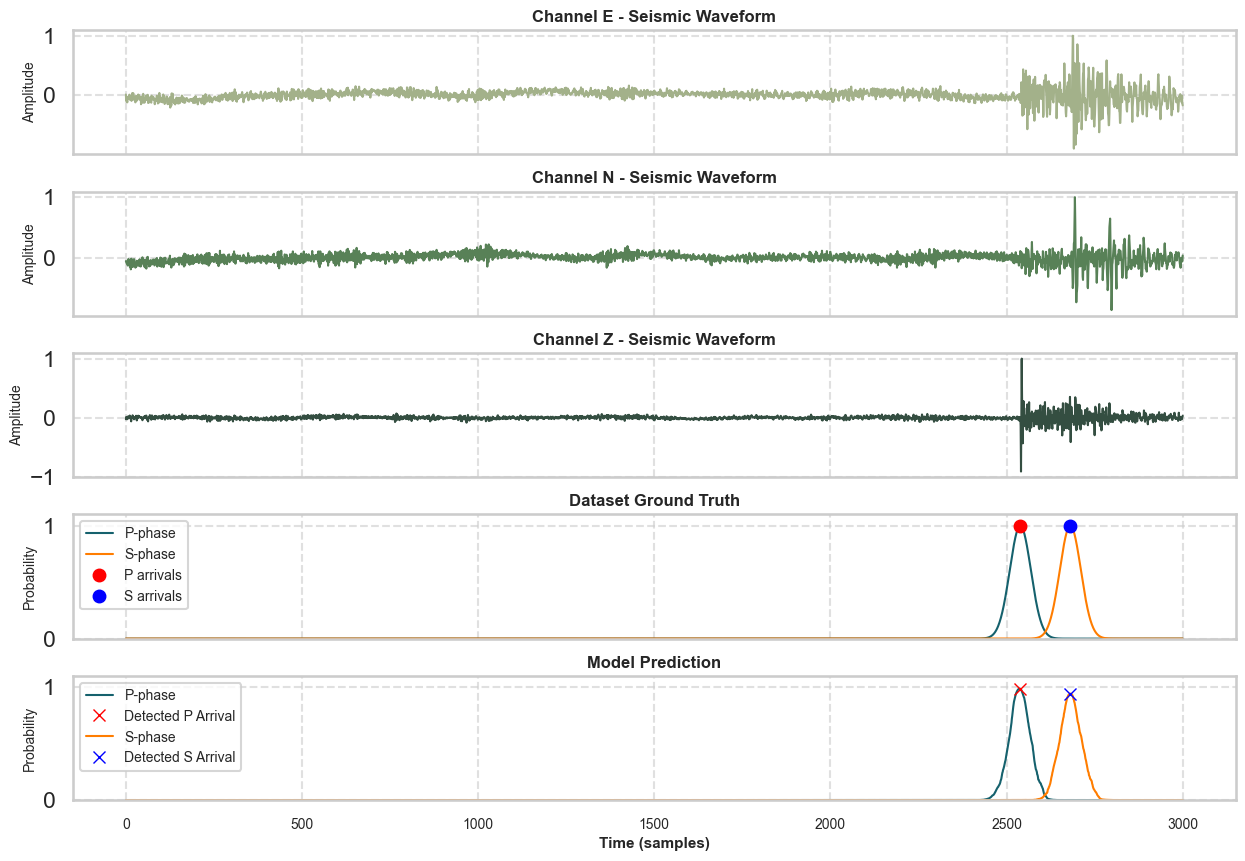

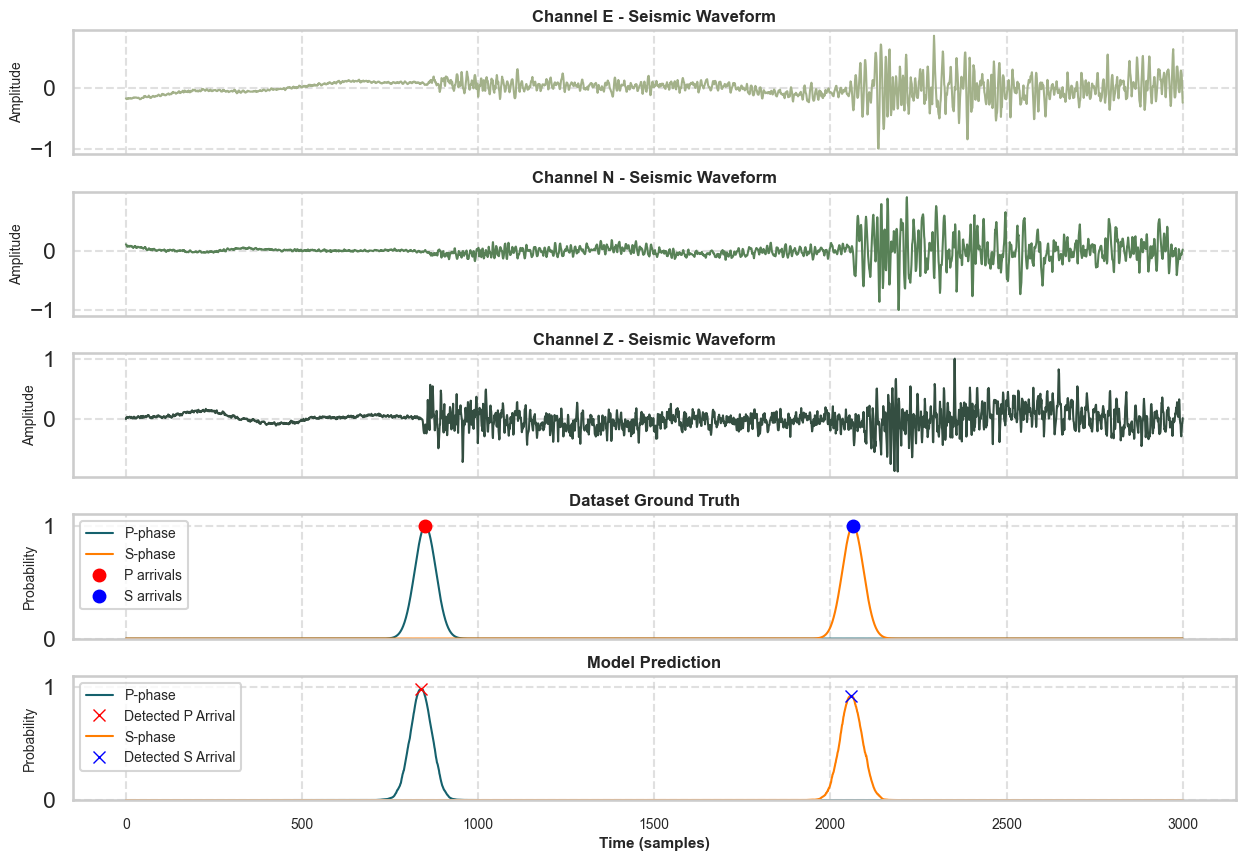

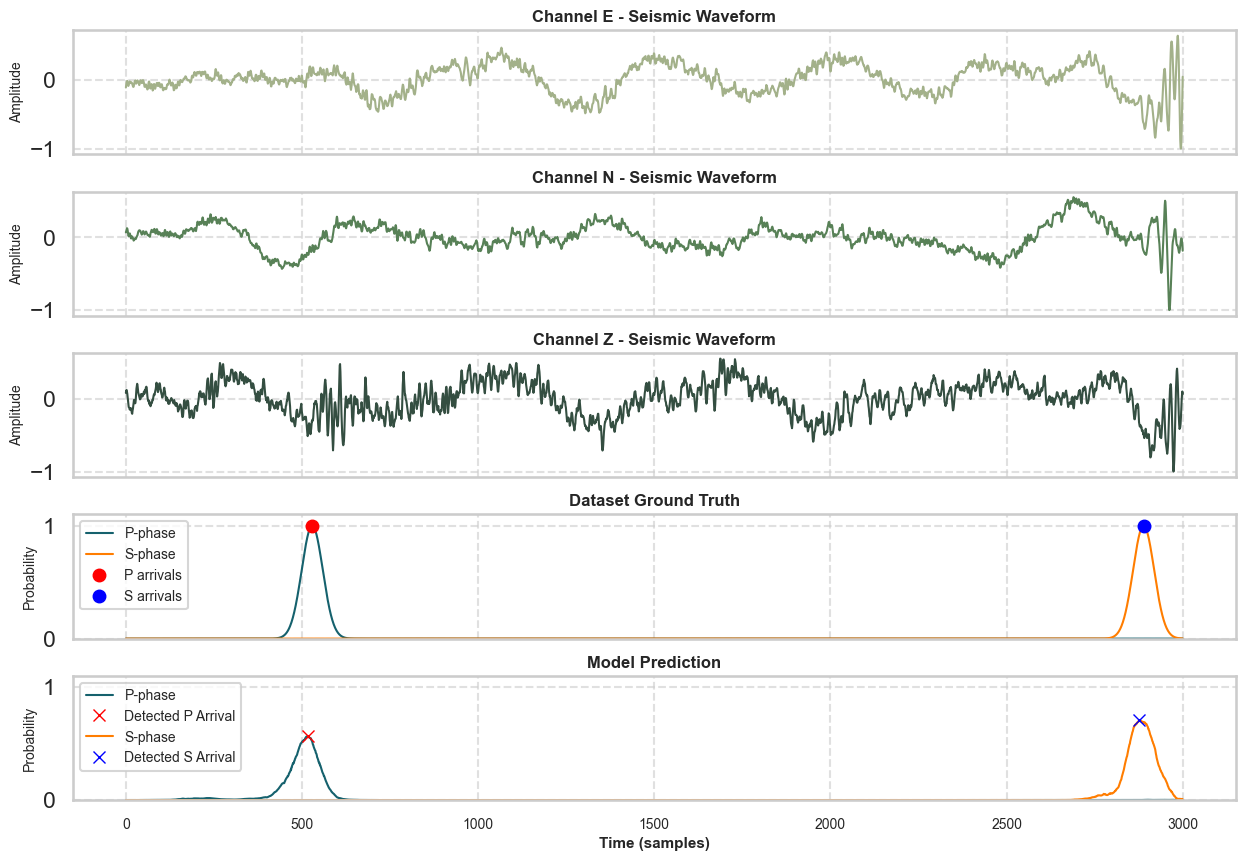

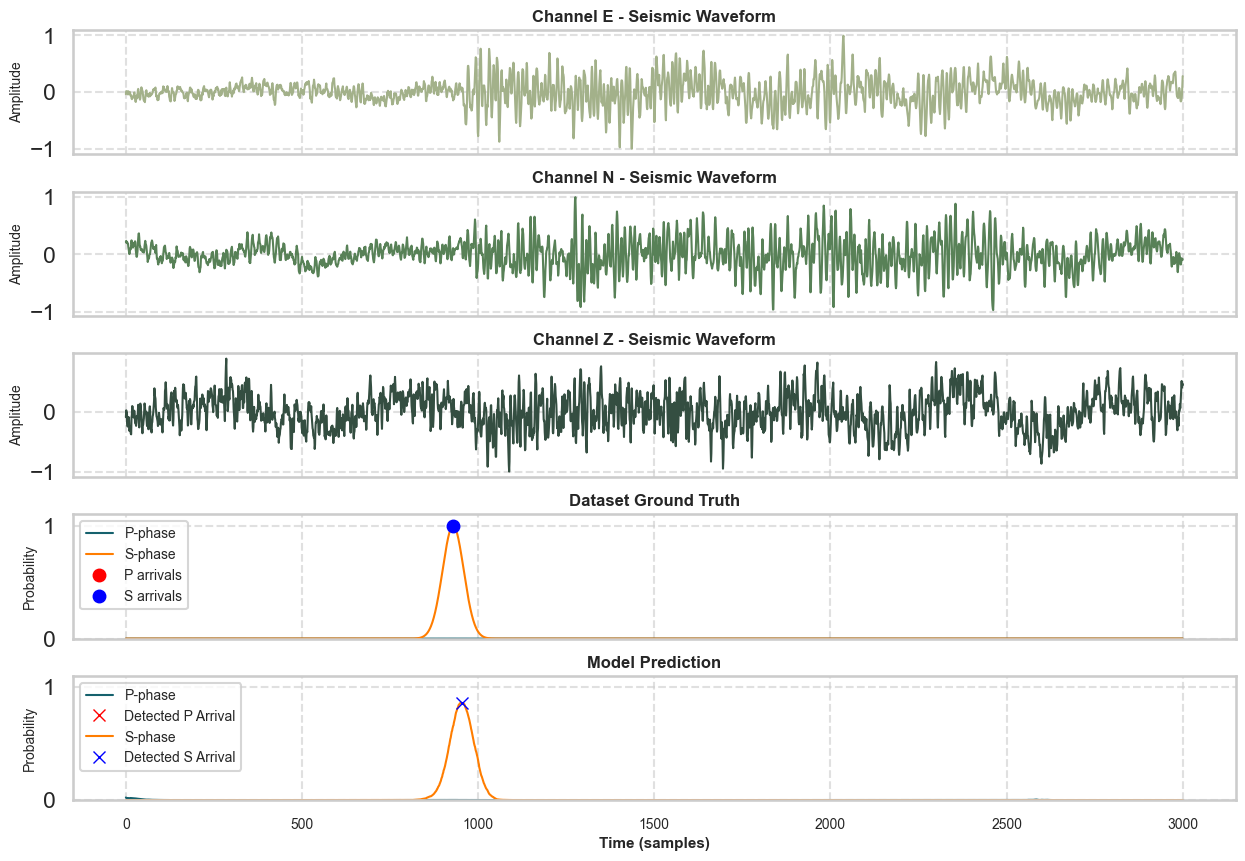

In [81]:
# Run the prediction 4 times
for i in range(1, 5):
    # Visualizing Predictions
    sample = test_generator[np.random.randint(len(test_generator))]

    waveform = sample["X"]  # Shape: (3, N)
    labels = sample["y"]  # Shape: (3, N)

    time_axis = np.arange(waveform.shape[1])  # Create a time axis

    fig = plt.figure(figsize=(15, 10))
    axs = fig.subplots(5, 1, sharex=True, gridspec_kw={"hspace": 0.3})

    # Color setup
    channel_names = ["Channel E", "Channel N", "Channel Z"]
    waveform_colors = ['#a3b18a', '#588157', '#344e41']  # Custom colors for channels
    label_colors = ['#15616d', '#ff7d00']

    # Plot waveforms
    for j in range(3):
        axs[j].plot(time_axis, waveform[j], color=waveform_colors[j], linewidth=1.5)
        axs[j].set_title(f"{channel_names[j]} - Seismic Waveform", fontsize=12, fontweight='bold')
        axs[j].set_ylabel("Amplitude", fontsize=10)
        axs[j].grid(True, linestyle='--', alpha=0.6)
    
    #axs[0].plot(sample["X"].T)
    #axs[1].plot(sample["y"].T)

    # Find peaks in the ground truth labels
    y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
    y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)

    # Convert ground truth peak indices to time values
    y_p_arrival_times = y_p_peaks / sampling_rate
    y_s_arrival_times = y_s_peaks / sampling_rate

    axs[3].plot(time_axis, labels[0], color=label_colors[0], linewidth=1.5, label="P-phase")
    axs[3].plot(time_axis, labels[1], color=label_colors[1], linewidth=1.5, label="S-phase")
    axs[3].plot(y_p_peaks, sample["y"][0, y_p_peaks], 'o', label='P arrivals', color='red')
    axs[3].plot(y_s_peaks, sample["y"][1, y_s_peaks], 'o', label='S arrivals', color='blue')
    axs[3].set_title("Dataset Ground Truth", fontsize=12, fontweight='bold')
    axs[3].set_ylim(0,1.1)
    axs[3].set_ylabel("Probability", fontsize=10)
    axs[3].grid(True, linestyle='--', alpha=0.6)
    axs[3].legend(fontsize=10, loc="upper left")
    
    teacher_model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        pred = teacher_model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()

    # Extract the probability distributions for P and S phases
    p_prob = pred[0]
    s_prob = pred[1]

    # Identify peaks in the probability distributions
    p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
    s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)

    # Convert peak indices to time values
    p_arrival_times = p_peaks / sampling_rate
    s_arrival_times = s_peaks / sampling_rate

    # Calculate residuals
    residual_p_arrival_times = p_arrival_times - y_p_arrival_times[:, np.newaxis]
    residual_s_arrival_times = s_arrival_times - y_s_arrival_times[:, np.newaxis]

    # Plot the probability distributions and the detected peaks
    axs[4].plot(p_prob, color=label_colors[0], linewidth=1.5,label='P-phase')
    axs[4].plot(p_peaks, p_prob[p_peaks], 'x', label='Detected P Arrival', color='red')
    axs[4].plot(s_prob, color=label_colors[1], linewidth=1.5,label='S-phase')
    axs[4].plot(s_peaks, s_prob[s_peaks], 'x', label='Detected S Arrival', color='blue')
    axs[4].set_title('Model Prediction', fontsize=12, fontweight='bold')
    axs[4].set_ylim(0,1.1)
    axs[4].grid(True, linestyle='--', alpha=0.6)
    axs[4].set_ylabel('Probability', fontsize=10)
    axs[4].legend(fontsize=10, loc="upper left")

    # Improve x-axis visibility
    axs[4].set_xlabel("Time (samples)", fontsize=11, fontweight='bold')
    axs[4].tick_params(axis='x', labelsize=10)

    #plt.tight_layout()
    plot_filename = os.path.join(output_folder, f"Okla_Teacher_Model_Pred_{i:03d}_Plot.png")
    plt.savefig(plot_filename)
    plt.show()
    plt.close(fig)

    # Save the results to a text file
    results_filename = os.path.join(output_folder, f"Okla_Teacher_Model_Pred_{i:03d}_Results.txt")
    with open(results_filename, "w") as f:
        f.write(f"Ground Truth P arrival times: {y_p_arrival_times}\n")
        f.write(f"Ground Truth S arrival times: {y_s_arrival_times}\n")
        f.write(f"Model Predicted P arrival times: {p_arrival_times}\n")
        f.write(f"Model Predicted S arrival times: {s_arrival_times}\n")
        f.write(f"Residual P arrival times: {residual_p_arrival_times}\n")
        f.write(f"Residual S arrival times: {residual_s_arrival_times}\n")

    # Save the parameters to a text file
    parameters_filename = os.path.join(output_folder, f"Okla_Teacher_Model_Pred_{i:03d}_Parameters.txt")
    with open(parameters_filename, "w") as f:
        f.write(f"Data Sampling Rate: {sampling_rate}\n")
        f.write(f"Detection Height Parameter: {height}\n")
        f.write(f"Detection Distance Parameter: {distance}\n")


Total ground truth P peaks: 624
Total ground truth S peaks: 618
Total P-phase residuals under 0.6s: 503
Total S-phase residuals under 0.6s: 505
P-phase Residuals: Mean = 0.0677, Std = 1.4803
Total detected P picks: 531


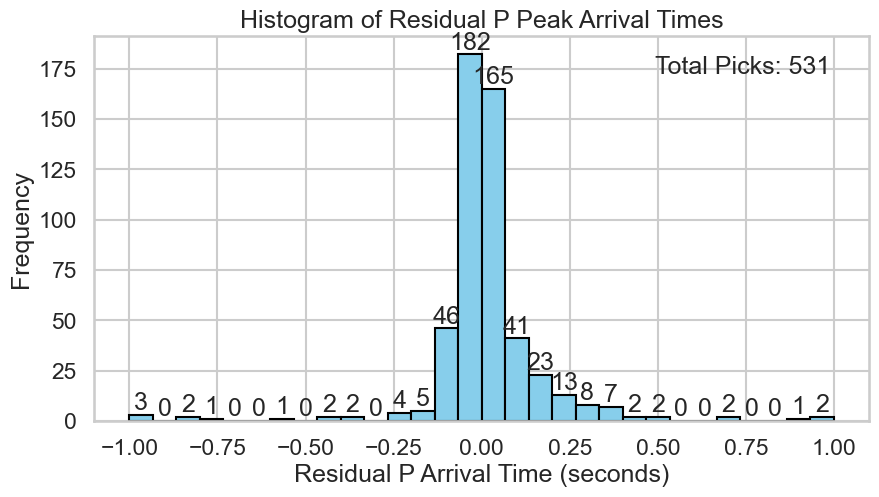

S-phase Residuals: Mean = 0.0349, Std = 0.4451
Total detected S picks: 526


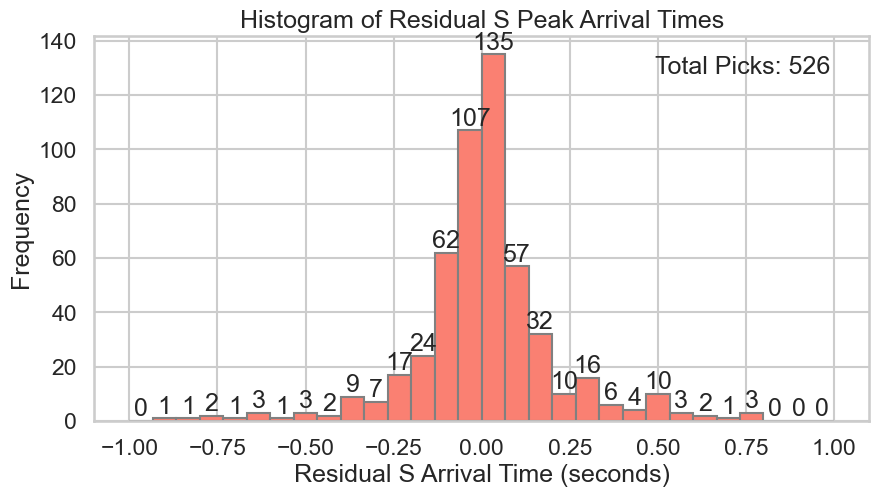

In [82]:
n_samples = len(test_generator)

all_residual_p_arrival_times = []
all_residual_s_arrival_times = []

# Initialize counters for ground truth P and S labels
groundtruth_p_peaks = 0
groundtruth_s_peaks = 0

# Initialize counters for residuals smaller than 0.6 (absolute value)
count_residuals_p_under_0_6 = 0
count_residuals_s_under_0_6 = 0

# Only Commenting this out to reflect the randome samples to squential samples 

for i in range(n_samples):
#for i in range(len(test_generator)):
    
    # Hongyu Xiao: randome sample works effectively
    sample = test_generator[np.random.randint(len(test_generator))]

    #sample = test_generator[i]

    # Find peaks in the ground truth labels
    y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
    y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)

    # Update the counters
    groundtruth_p_peaks += len(y_p_peaks)
    groundtruth_s_peaks += len(y_s_peaks)

    # Convert ground truth peak indices to time values
    sampling_rate = 100  # Samples per second (100 Hz)
    y_p_arrival_times = y_p_peaks / sampling_rate
    y_s_arrival_times = y_s_peaks / sampling_rate

    teacher_model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        pred = teacher_model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()

    # Extract the probability distributions for P and S phases
    p_prob = pred[0]
    s_prob = pred[1]

    # Identify peaks in the probability distributions
    p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
    s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)

    # Convert peak indices to time values
    p_arrival_times = p_peaks / sampling_rate
    s_arrival_times = s_peaks / sampling_rate

    # Calculate residuals for P and S peaks, keeping only the smallest one by absolute value
    for y_p_time in y_p_arrival_times:
        residual_p_arrival_times = p_arrival_times - y_p_time
        if len(residual_p_arrival_times) > 0:
            min_residual_p = residual_p_arrival_times[np.argmin(np.abs(residual_p_arrival_times))]
            all_residual_p_arrival_times.append(min_residual_p)
            if np.abs(min_residual_p) < 0.6:
                count_residuals_p_under_0_6 += 1
        
    for y_s_time in y_s_arrival_times:
        residual_s_arrival_times = s_arrival_times - y_s_time
        if len(residual_s_arrival_times) > 0:
            min_residual_s = residual_s_arrival_times[np.argmin(np.abs(residual_s_arrival_times))]
            all_residual_s_arrival_times.append(min_residual_s)
            if np.abs(min_residual_s) < 0.6:
                count_residuals_s_under_0_6 += 1

# Display the total counts of ground truth P and S peaks
print(f"Total ground truth P peaks: {groundtruth_p_peaks}")
print(f"Total ground truth S peaks: {groundtruth_s_peaks}")

# Display the counts of residuals under 0.6 seconds
print(f"Total P-phase residuals under 0.6s: {count_residuals_p_under_0_6}")
print(f"Total S-phase residuals under 0.6s: {count_residuals_s_under_0_6}")

# Plot the histogram of residual P peak arrival times
plt.figure(figsize=(10, 5))
counts_p, bins_p, patches_p = plt.hist(all_residual_p_arrival_times, bins=30, color='skyblue', edgecolor='black', range=(-1, 1))

# Add labels for the number counts on each column
for count, bin_, patch in zip(counts_p, bins_p, patches_p):
    plt.text(bin_ + (bins_p[1] - bins_p[0]) / 2, count, f'{int(count)}', ha='center', va='bottom')

# Print total pick count, mean, and standard deviation
total_picks_p = len(all_residual_p_arrival_times)
mean_p = np.mean(all_residual_p_arrival_times)
std_p = np.std(all_residual_p_arrival_times)
plt.text(0.95, 0.95, f'Total Picks: {total_picks_p}', ha='right', va='top', transform=plt.gca().transAxes)
print(f"P-phase Residuals: Mean = {mean_p:.4f}, Std = {std_p:.4f}")
print(f"Total detected P picks: {total_picks_p}")

plt.title('Histogram of Residual P Peak Arrival Times')
plt.xlabel('Residual P Arrival Time (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("teacher_model_residual_p_histogram.png")  # Save the figure as a PNG file
plt.show()

# Plot the histogram of residual S peak arrival times
plt.figure(figsize=(10, 5))
counts_s, bins_s, patches_s = plt.hist(all_residual_s_arrival_times, bins=30, color='salmon', edgecolor='grey', range=(-1, 1))

# Add labels for the number counts on each column
for count, bin_, patch in zip(counts_s, bins_s, patches_s):
    plt.text(bin_ + (bins_s[1] - bins_s[0]) / 2, count, f'{int(count)}', ha='center', va='bottom')

# Print total pick count, mean, and standard deviation
total_picks_s = len(all_residual_s_arrival_times)
mean_s = np.mean(all_residual_s_arrival_times)
std_s = np.std(all_residual_s_arrival_times)
plt.text(0.95, 0.95, f'Total Picks: {total_picks_s}', ha='right', va='top', transform=plt.gca().transAxes)
print(f"S-phase Residuals: Mean = {mean_s:.4f}, Std = {std_s:.4f}")
print(f"Total detected S picks: {total_picks_s}")

plt.title('Histogram of Residual S Peak Arrival Times')
plt.xlabel('Residual S Arrival Time (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("teacher_model_residual_s_histogram.png")  # Save the figure as a PNG file
plt.show()

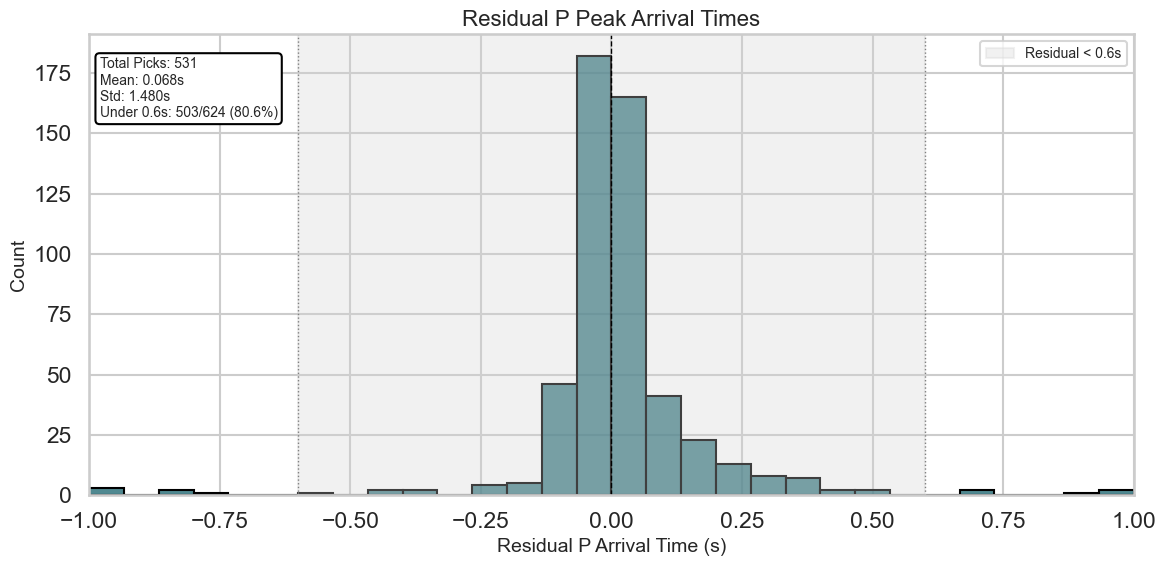

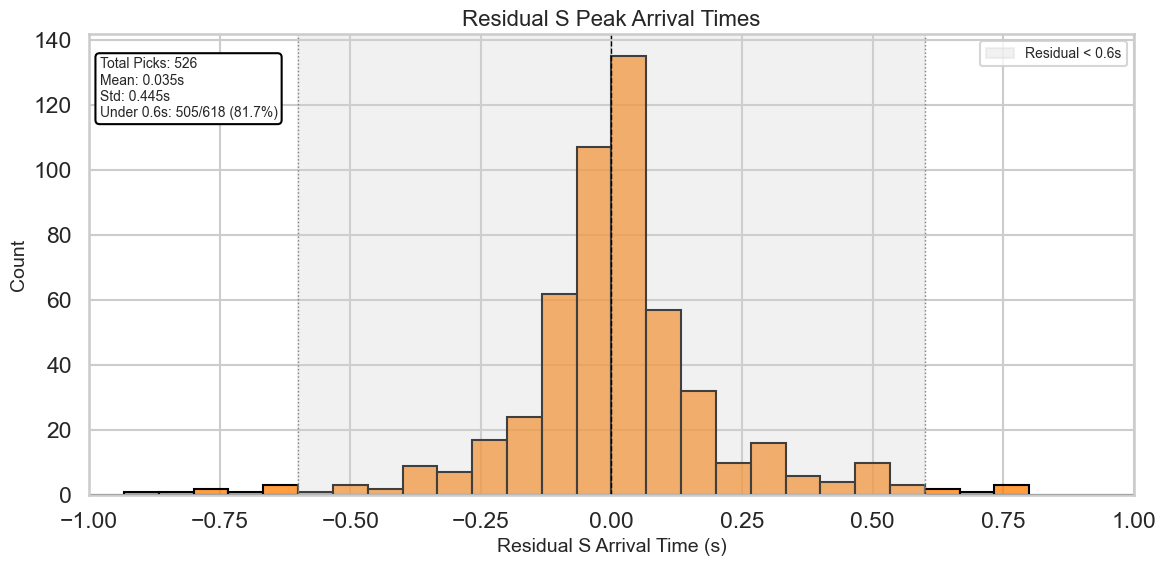

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Seaborn style
sns.set(style="whitegrid", context="talk")

# Parameters
x_min, x_max = -1, 1
bins = np.linspace(x_min, x_max, 31)  # 30 bins between -1 and 1

# Custom colors
p_color = '#15616d'
s_color = '#ff7d00'
shading_color = '#d3d3d3'  # light gray for shaded success zone

# === P-phase residuals ===
plt.figure(figsize=(12, 6))
sns.histplot(all_residual_p_arrival_times, bins=bins, kde=False, color=p_color, edgecolor='black', stat='count')

# Shaded ±0.6s zone
plt.axvspan(-0.6, 0.6, color=shading_color, alpha=0.3, label='Residual < 0.6s')

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(-0.6, color='gray', linestyle=':', linewidth=1)
plt.axvline(0.6, color='gray', linestyle=':', linewidth=1)

# Stats and annotation
mean_p = np.mean(all_residual_p_arrival_times)
std_p = np.std(all_residual_p_arrival_times)
total_picks_p = len(all_residual_p_arrival_times)
fraction_p = count_residuals_p_under_0_6 / groundtruth_p_peaks

plt.text(x_min + 0.02, plt.gca().get_ylim()[1]*0.95,
         f'Total Picks: {total_picks_p}\nMean: {mean_p:.3f}s\nStd: {std_p:.3f}s\nUnder 0.6s: {count_residuals_p_under_0_6}/{groundtruth_p_peaks} ({fraction_p:.1%})',
         ha='left', va='top', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))

plt.title('Residual P Peak Arrival Times', fontsize=16)
plt.xlabel('Residual P Arrival Time (s)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(x_min, x_max)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("teacher_model_residual_p_histogram_shaded.png")
#plt.savefig("teacher_model_residual_p_histogram_shaded.ps")
plt.show()


# === S-phase residuals ===
plt.figure(figsize=(12, 6))
sns.histplot(all_residual_s_arrival_times, bins=bins, kde=False, color=s_color, edgecolor='black', stat='count')

# Shaded ±0.6s zone
plt.axvspan(-0.6, 0.6, color=shading_color, alpha=0.3, label='Residual < 0.6s')

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(-0.6, color='gray', linestyle=':', linewidth=1)
plt.axvline(0.6, color='gray', linestyle=':', linewidth=1)

# Stats and annotation
mean_s = np.mean(all_residual_s_arrival_times)
std_s = np.std(all_residual_s_arrival_times)
total_picks_s = len(all_residual_s_arrival_times)
fraction_s = count_residuals_s_under_0_6 / groundtruth_s_peaks

plt.text(x_min + 0.02, plt.gca().get_ylim()[1]*0.95,
         f'Total Picks: {total_picks_s}\nMean: {mean_s:.3f}s\nStd: {std_s:.3f}s\nUnder 0.6s: {count_residuals_s_under_0_6}/{groundtruth_s_peaks} ({fraction_s:.1%})',
         ha='left', va='top', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))

plt.title('Residual S Peak Arrival Times', fontsize=16)
plt.xlabel('Residual S Arrival Time (s)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(x_min, x_max)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("teacher_model_residual_s_histogram_shaded.png")
#plt.savefig("teacher_model_residual_s_histogram_shaded.ps")
plt.show()


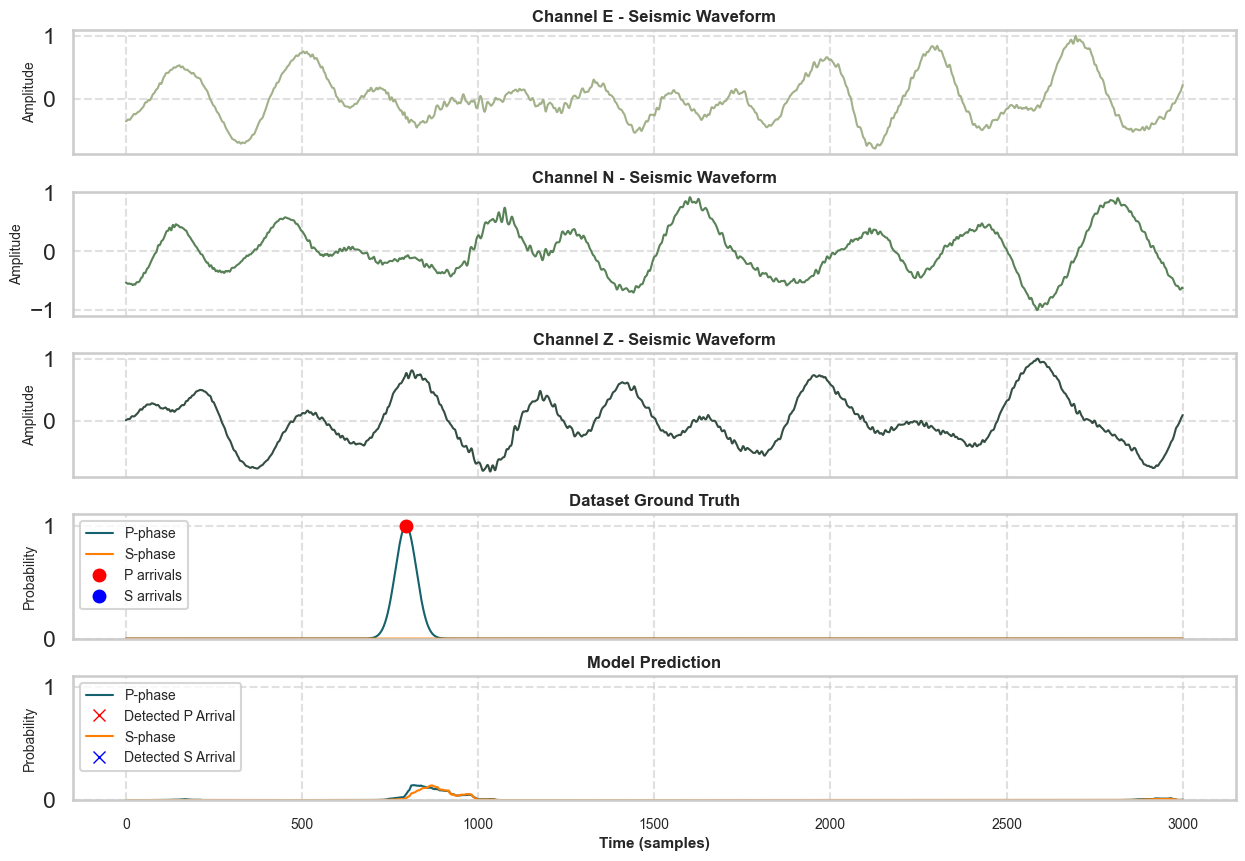

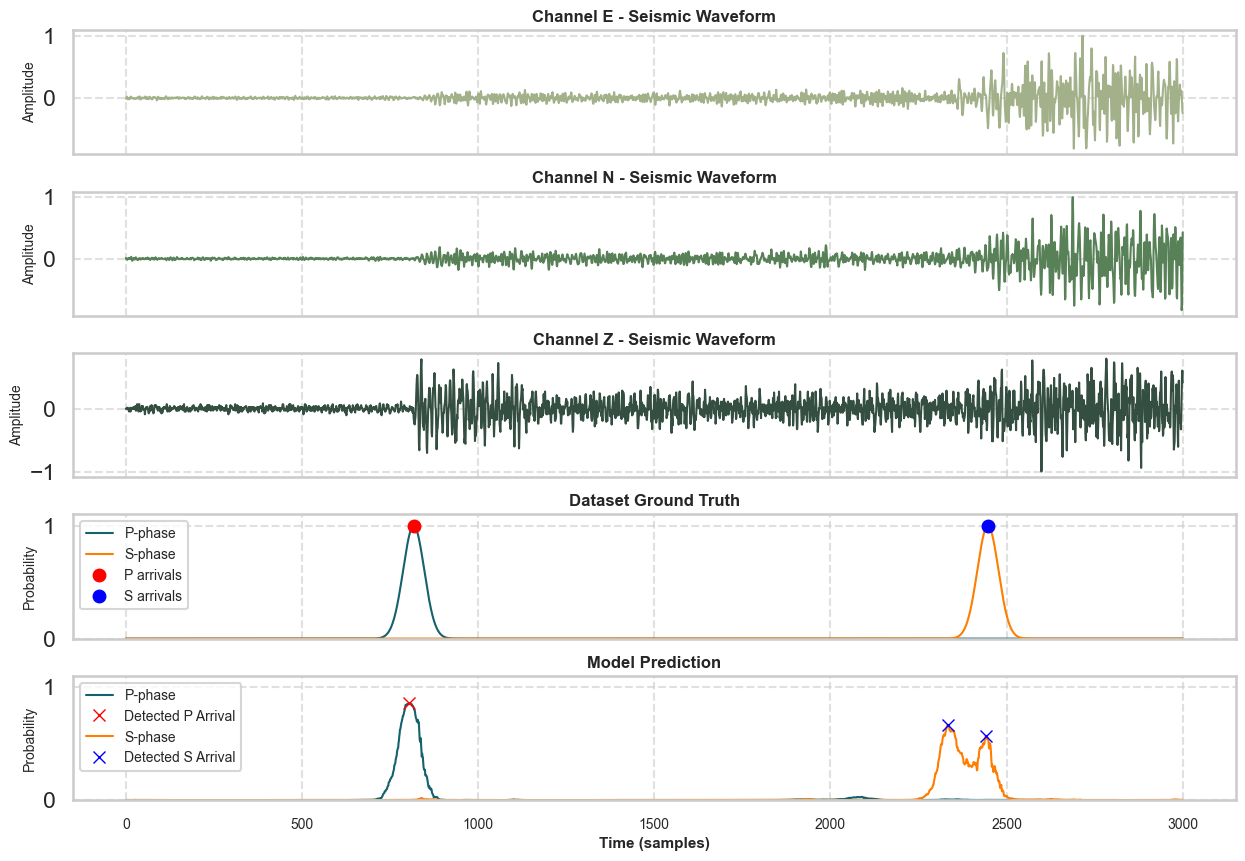

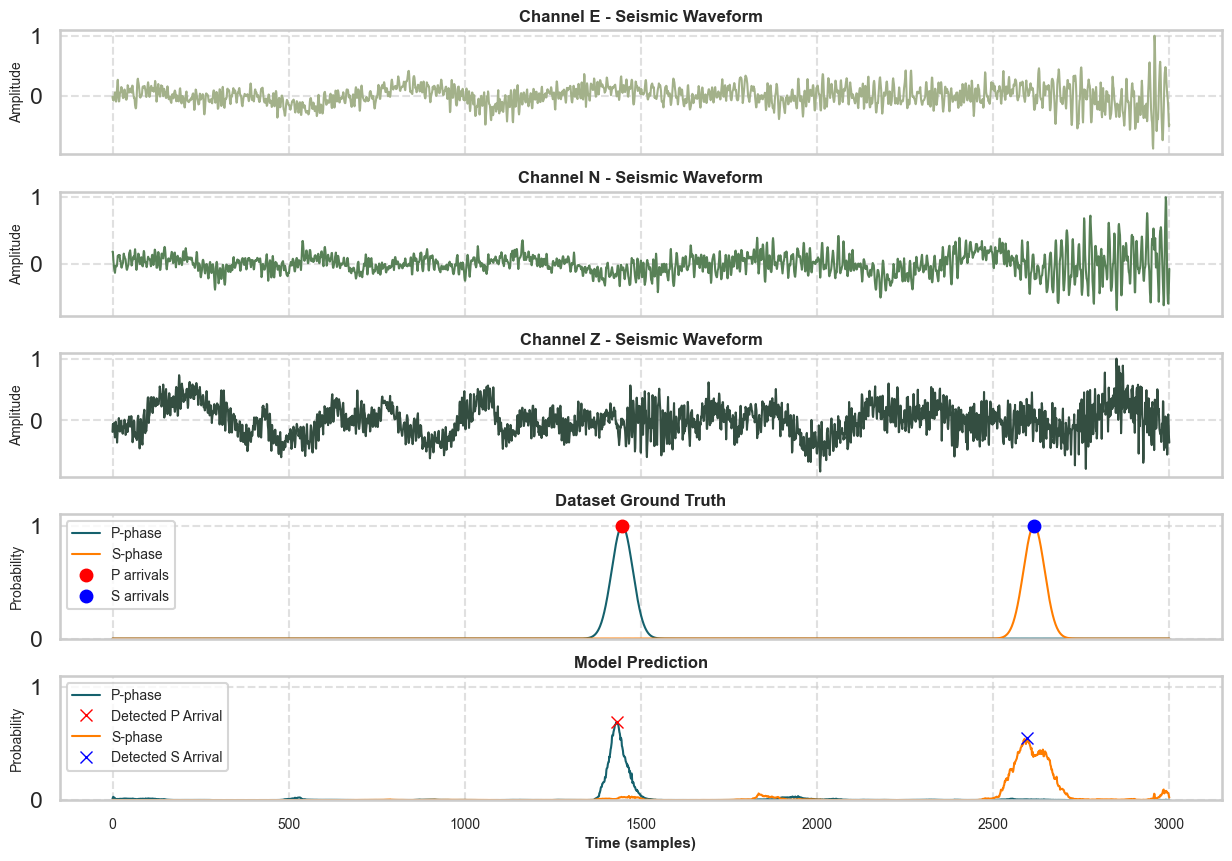

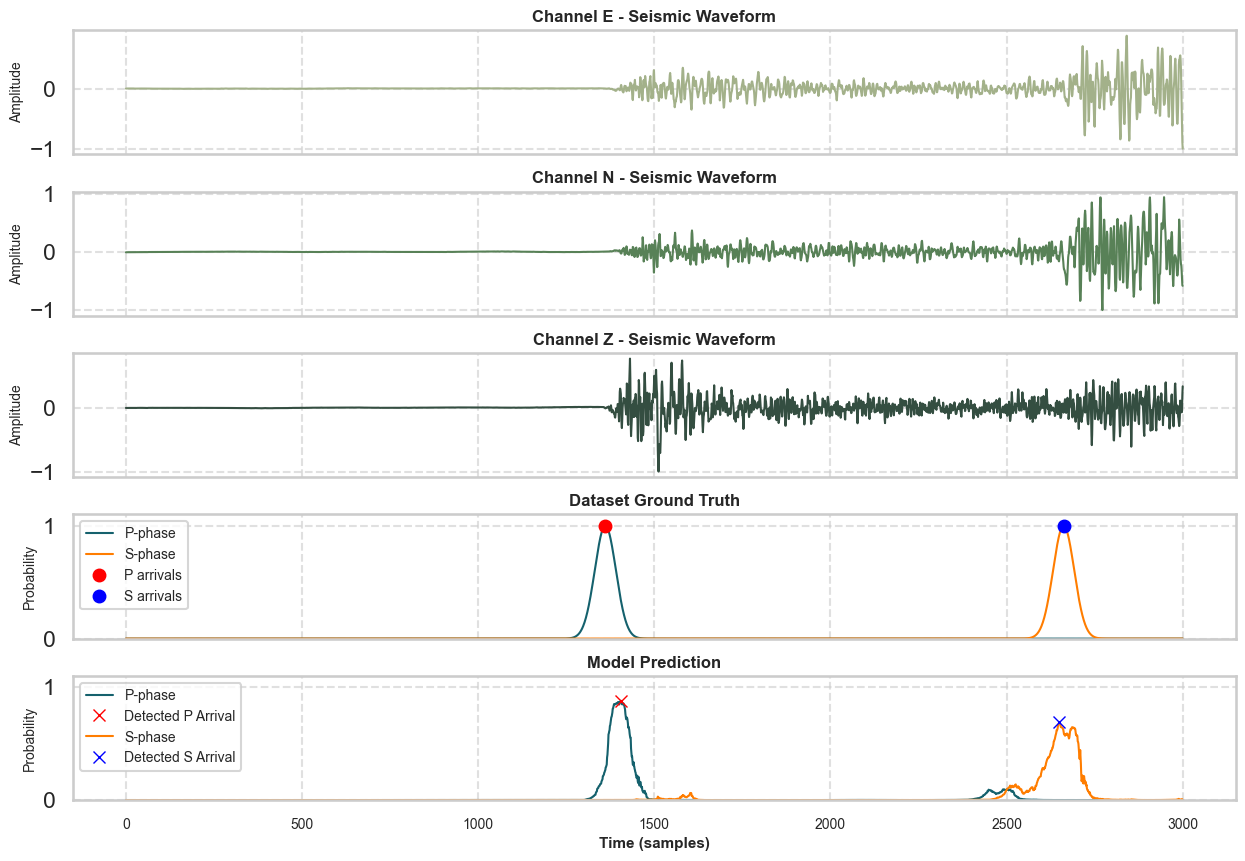

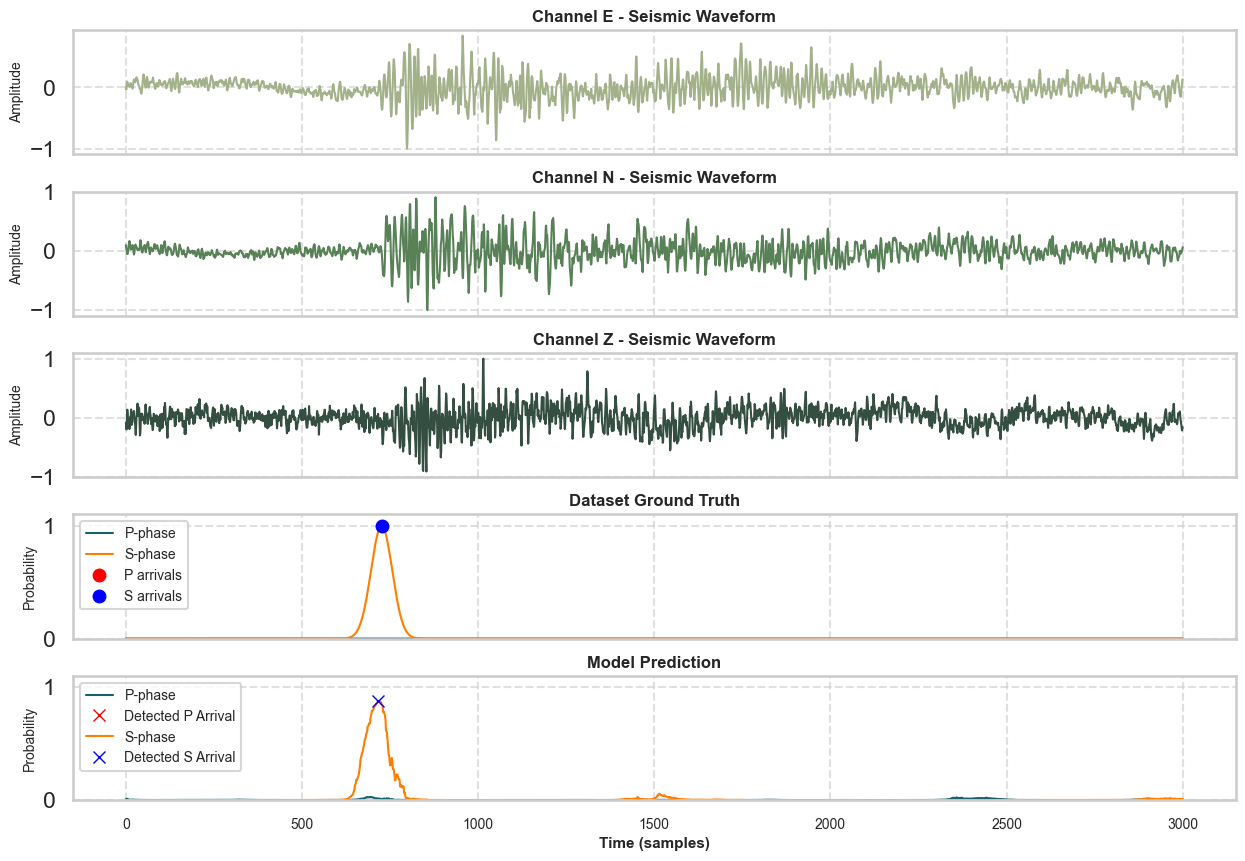

In [84]:
# Run the prediction 5 times
for i in range(1, 6):
    # Visualizing Predictions
    sample = test_generator[np.random.randint(len(test_generator))]

    waveform = sample["X"]  # Shape: (3, N)
    labels = sample["y"]  # Shape: (3, N)

    time_axis = np.arange(waveform.shape[1])  # Create a time axis

    fig = plt.figure(figsize=(15, 10))
    axs = fig.subplots(5, 1, sharex=True, gridspec_kw={"hspace": 0.3})

    # Color setup
    channel_names = ["Channel E", "Channel N", "Channel Z"]
    waveform_colors = ['#a3b18a', '#588157', '#344e41']  # Custom colors for channels
    label_colors = ['#15616d', '#ff7d00']

    # Plot waveforms
    for j in range(3):
        axs[j].plot(time_axis, waveform[j], color=waveform_colors[j], linewidth=1.5)
        axs[j].set_title(f"{channel_names[j]} - Seismic Waveform", fontsize=12, fontweight='bold')
        axs[j].set_ylabel("Amplitude", fontsize=10)
        axs[j].grid(True, linestyle='--', alpha=0.6)
    
    #axs[0].plot(sample["X"].T)
    #axs[1].plot(sample["y"].T)

    # Find peaks in the ground truth labels
    y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
    y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)

    # Convert ground truth peak indices to time values
    y_p_arrival_times = y_p_peaks / sampling_rate
    y_s_arrival_times = y_s_peaks / sampling_rate

    axs[3].plot(time_axis, labels[0], color=label_colors[0], linewidth=1.5, label="P-phase")
    axs[3].plot(time_axis, labels[1], color=label_colors[1], linewidth=1.5, label="S-phase")
    axs[3].plot(y_p_peaks, sample["y"][0, y_p_peaks], 'o', label='P arrivals', color='red')
    axs[3].plot(y_s_peaks, sample["y"][1, y_s_peaks], 'o', label='S arrivals', color='blue')
    axs[3].set_title("Dataset Ground Truth", fontsize=12, fontweight='bold')
    axs[3].set_ylim(0,1.1)
    axs[3].set_ylabel("Probability", fontsize=10)
    axs[3].grid(True, linestyle='--', alpha=0.6)
    axs[3].legend(fontsize=10, loc="upper left")
    
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()

    # Extract the probability distributions for P and S phases
    p_prob = pred[0]
    s_prob = pred[1]

    # Identify peaks in the probability distributions
    p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
    s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)

    # Convert peak indices to time values
    p_arrival_times = p_peaks / sampling_rate
    s_arrival_times = s_peaks / sampling_rate

    # Calculate residuals
    residual_p_arrival_times = p_arrival_times - y_p_arrival_times[:, np.newaxis]
    residual_s_arrival_times = s_arrival_times - y_s_arrival_times[:, np.newaxis]

    # Plot the probability distributions and the detected peaks
    axs[4].plot(p_prob, color=label_colors[0], linewidth=1.5,label='P-phase')
    axs[4].plot(p_peaks, p_prob[p_peaks], 'x', label='Detected P Arrival', color='red')
    axs[4].plot(s_prob, color=label_colors[1], linewidth=1.5,label='S-phase')
    axs[4].plot(s_peaks, s_prob[s_peaks], 'x', label='Detected S Arrival', color='blue')
    axs[4].set_title('Model Prediction', fontsize=12, fontweight='bold')
    axs[4].set_ylim(0,1.1)
    axs[4].grid(True, linestyle='--', alpha=0.6)
    axs[4].set_ylabel('Probability', fontsize=10)
    axs[4].legend(fontsize=10, loc="upper left")

    # Improve x-axis visibility
    axs[4].set_xlabel("Time (samples)", fontsize=11, fontweight='bold')
    axs[4].tick_params(axis='x', labelsize=10)

    #plt.tight_layout()
    plot_filename = os.path.join(output_folder, f"Okla_Model_Pred_{i:03d}_Plot.png")
    plt.savefig(plot_filename)
    plt.show()
    plt.close(fig)

    # Save the results to a text file
    results_filename = os.path.join(output_folder, f"Okla_Model_Pred_{i:03d}_Results.txt")
    with open(results_filename, "w") as f:
        f.write(f"Ground Truth P arrival times: {y_p_arrival_times}\n")
        f.write(f"Ground Truth S arrival times: {y_s_arrival_times}\n")
        f.write(f"Model Predicted P arrival times: {p_arrival_times}\n")
        f.write(f"Model Predicted S arrival times: {s_arrival_times}\n")
        f.write(f"Residual P arrival times: {residual_p_arrival_times}\n")
        f.write(f"Residual S arrival times: {residual_s_arrival_times}\n")

    # Save the parameters to a text file
    parameters_filename = os.path.join(output_folder, f"Okla_Model_Pred_{i:03d}_Parameters.txt")
    with open(parameters_filename, "w") as f:
        f.write(f"Data Sampling Rate: {sampling_rate}\n")
        f.write(f"Detection Height Parameter: {height}\n")
        f.write(f"Detection Distance Parameter: {distance}\n")


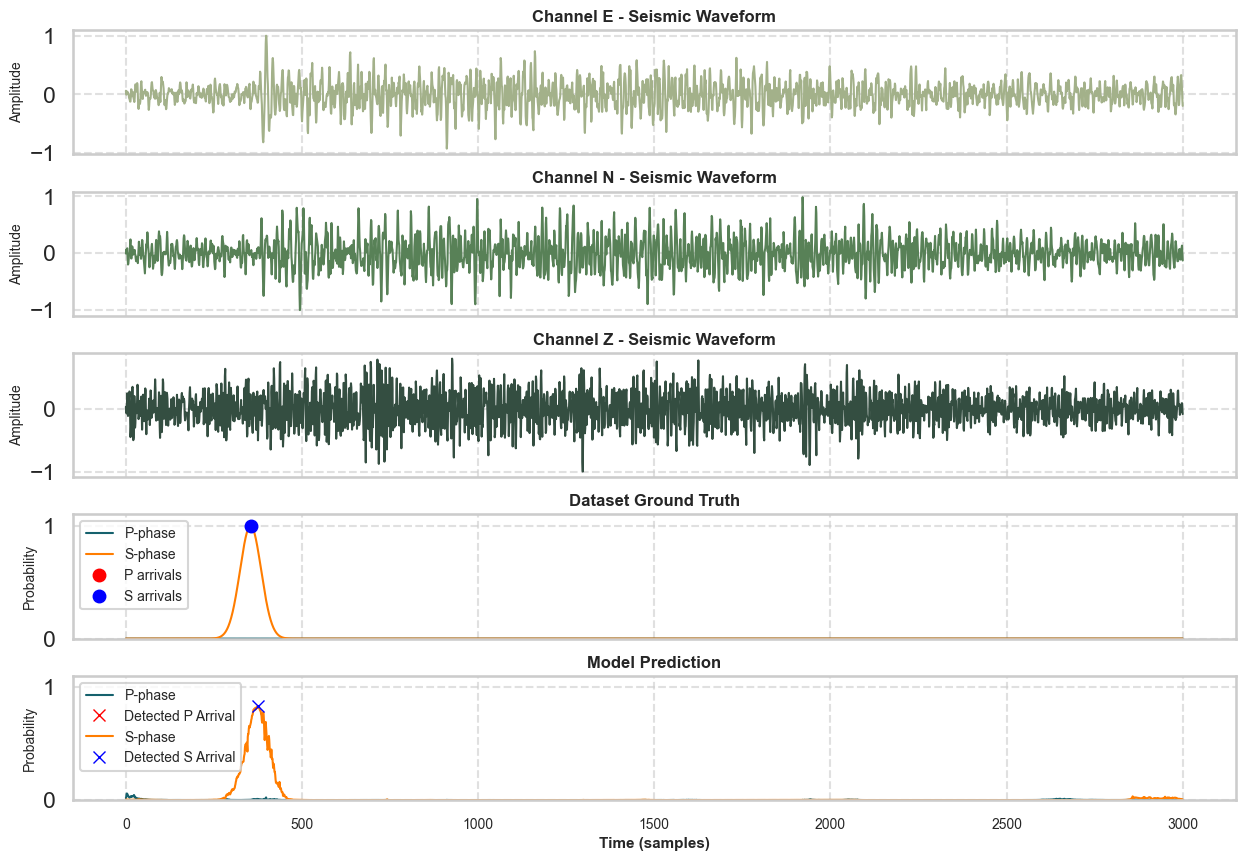

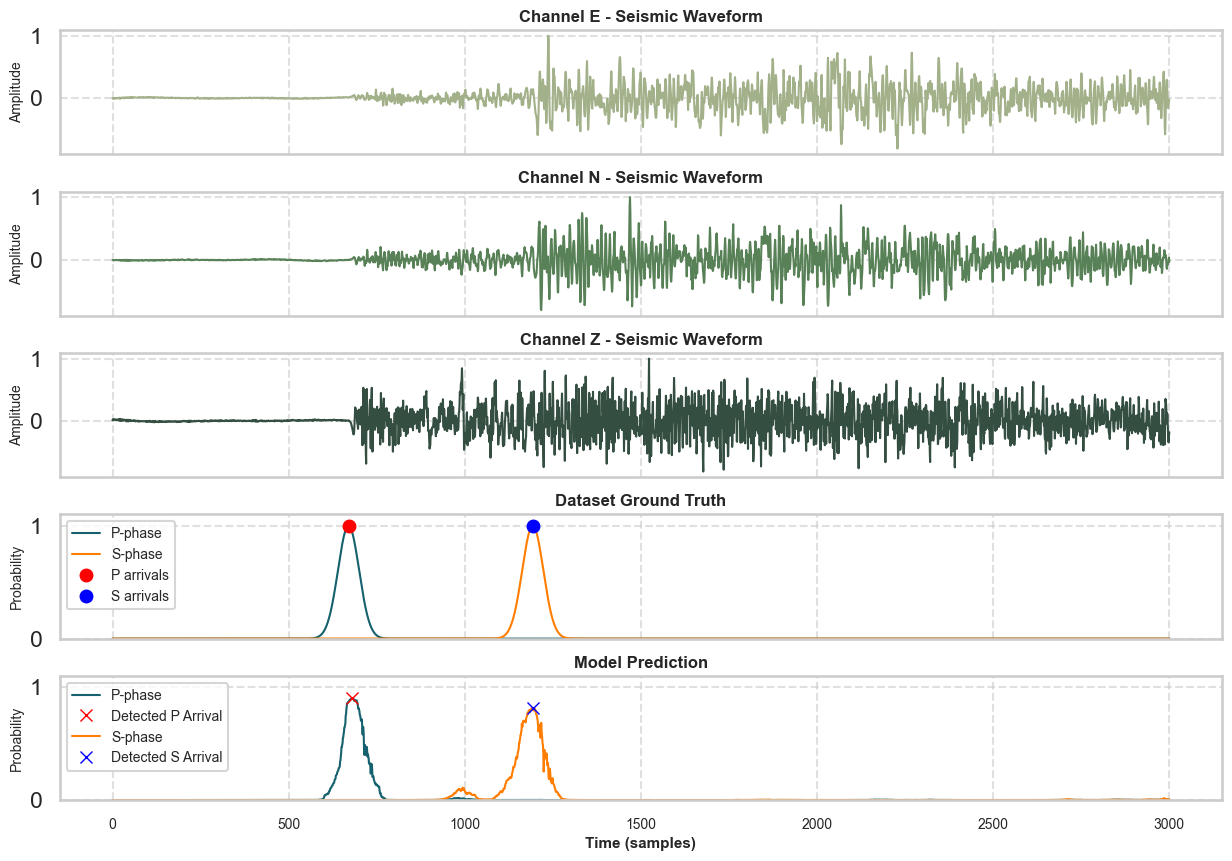

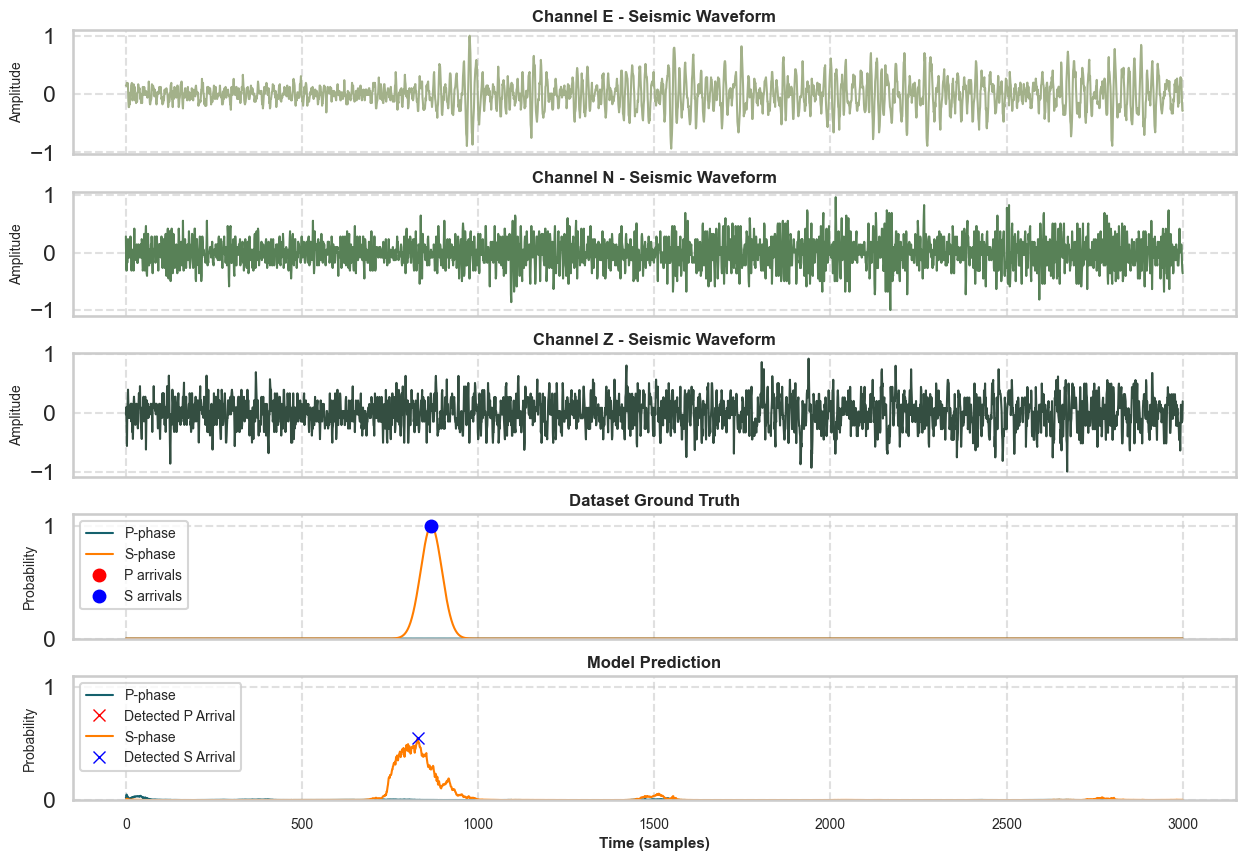

In [88]:
# Run the prediction 3 times
for i in range(1, 4):
    # Visualizing Predictions
    sample = test_generator[np.random.randint(len(test_generator))]

    waveform = sample["X"]  # Shape: (3, N)
    labels = sample["y"]  # Shape: (3, N)

    time_axis = np.arange(waveform.shape[1])  # Create a time axis

    fig = plt.figure(figsize=(15, 10))
    axs = fig.subplots(5, 1, sharex=True, gridspec_kw={"hspace": 0.3})

    # Color setup
    channel_names = ["Channel E", "Channel N", "Channel Z"]
    waveform_colors = ['#a3b18a', '#588157', '#344e41']  # Custom colors for channels
    label_colors = ['#15616d', '#ff7d00']

    # Plot waveforms
    for j in range(3):
        axs[j].plot(time_axis, waveform[j], color=waveform_colors[j], linewidth=1.5)
        axs[j].set_title(f"{channel_names[j]} - Seismic Waveform", fontsize=12, fontweight='bold')
        axs[j].set_ylabel("Amplitude", fontsize=10)
        axs[j].grid(True, linestyle='--', alpha=0.6)
    
    #axs[0].plot(sample["X"].T)
    #axs[1].plot(sample["y"].T)

    # Find peaks in the ground truth labels
    y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
    y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)

    # Convert ground truth peak indices to time values
    y_p_arrival_times = y_p_peaks / sampling_rate
    y_s_arrival_times = y_s_peaks / sampling_rate

    axs[3].plot(time_axis, labels[0], color=label_colors[0], linewidth=1.5, label="P-phase")
    axs[3].plot(time_axis, labels[1], color=label_colors[1], linewidth=1.5, label="S-phase")
    axs[3].plot(y_p_peaks, sample["y"][0, y_p_peaks], 'o', label='P arrivals', color='red')
    axs[3].plot(y_s_peaks, sample["y"][1, y_s_peaks], 'o', label='S arrivals', color='blue')
    axs[3].set_title("Dataset Ground Truth", fontsize=12, fontweight='bold')
    axs[3].set_ylim(0,1.1)
    axs[3].set_ylabel("Probability", fontsize=10)
    axs[3].grid(True, linestyle='--', alpha=0.6)
    axs[3].legend(fontsize=10, loc="upper left")
    
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()

    # Extract the probability distributions for P and S phases
    p_prob = pred[0]
    s_prob = pred[1]

    # Identify peaks in the probability distributions
    p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
    s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)

    # Convert peak indices to time values
    p_arrival_times = p_peaks / sampling_rate
    s_arrival_times = s_peaks / sampling_rate

    # Calculate residuals
    residual_p_arrival_times = p_arrival_times - y_p_arrival_times[:, np.newaxis]
    residual_s_arrival_times = s_arrival_times - y_s_arrival_times[:, np.newaxis]

    # Plot the probability distributions and the detected peaks
    axs[4].plot(p_prob, color=label_colors[0], linewidth=1.5,label='P-phase')
    axs[4].plot(p_peaks, p_prob[p_peaks], 'x', label='Detected P Arrival', color='red')
    axs[4].plot(s_prob, color=label_colors[1], linewidth=1.5,label='S-phase')
    axs[4].plot(s_peaks, s_prob[s_peaks], 'x', label='Detected S Arrival', color='blue')
    axs[4].set_title('Model Prediction', fontsize=12, fontweight='bold')
    axs[4].set_ylim(0,1.1)
    axs[4].grid(True, linestyle='--', alpha=0.6)
    axs[4].set_ylabel('Probability', fontsize=10)
    axs[4].legend(fontsize=10, loc="upper left")

    # Improve x-axis visibility
    axs[4].set_xlabel("Time (samples)", fontsize=11, fontweight='bold')
    axs[4].tick_params(axis='x', labelsize=10)

    #plt.tight_layout()
    plot_filename = os.path.join(output_folder, f"Okla_Model_Pred_{i:03d}_Plot.png")
    plt.savefig(plot_filename)
    plt.show()
    plt.close(fig)

    # Save the results to a text file
    results_filename = os.path.join(output_folder, f"Okla_Model_Pred_{i:03d}_Results.txt")
    with open(results_filename, "w") as f:
        f.write(f"Ground Truth P arrival times: {y_p_arrival_times}\n")
        f.write(f"Ground Truth S arrival times: {y_s_arrival_times}\n")
        f.write(f"Model Predicted P arrival times: {p_arrival_times}\n")
        f.write(f"Model Predicted S arrival times: {s_arrival_times}\n")
        f.write(f"Residual P arrival times: {residual_p_arrival_times}\n")
        f.write(f"Residual S arrival times: {residual_s_arrival_times}\n")

    # Save the parameters to a text file
    parameters_filename = os.path.join(output_folder, f"Okla_Model_Pred_{i:03d}_Parameters.txt")
    with open(parameters_filename, "w") as f:
        f.write(f"Data Sampling Rate: {sampling_rate}\n")
        f.write(f"Detection Height Parameter: {height}\n")
        f.write(f"Detection Distance Parameter: {distance}\n")


Total ground truth P peaks: 637
Total ground truth S peaks: 635
Total P-phase residuals under 0.6s: 437
Total S-phase residuals under 0.6s: 529
P-phase Residuals: Mean = -0.0316, Std = 2.0976
Total detected P picks: 449


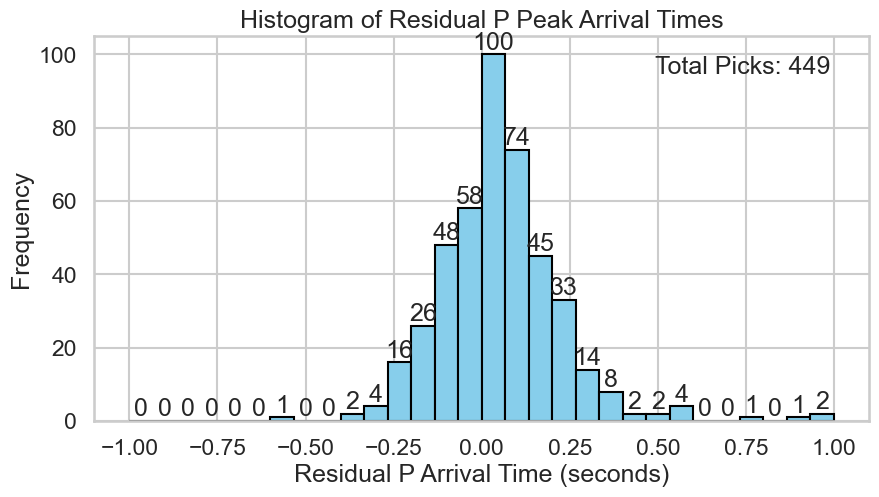

S-phase Residuals: Mean = 0.0341, Std = 1.0473
Total detected S picks: 549


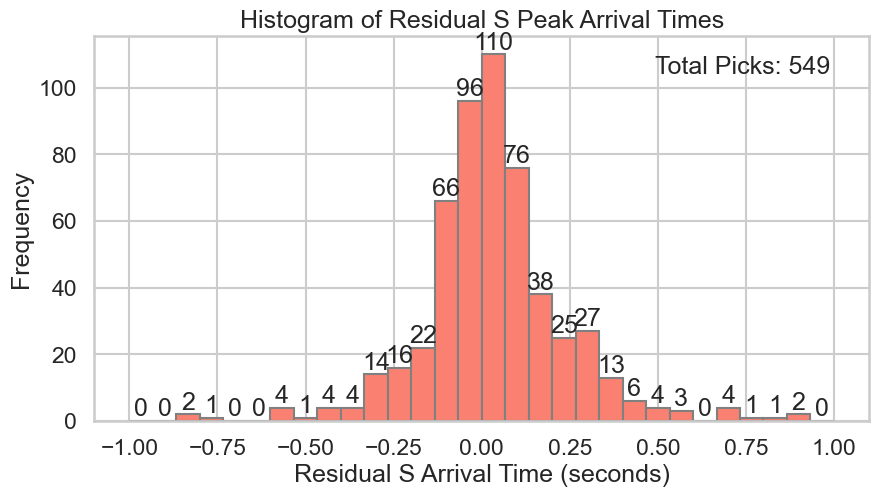

In [86]:

n_samples = len(test_generator)

all_residual_p_arrival_times = []
all_residual_s_arrival_times = []

# Initialize counters for ground truth P and S labels
groundtruth_p_peaks = 0
groundtruth_s_peaks = 0

# Initialize counters for residuals smaller than 0.6 (absolute value)
count_residuals_p_under_0_6 = 0
count_residuals_s_under_0_6 = 0

# Only Commenting this out to reflect the randome samples to squential samples 

for i in range(n_samples):
#for i in range(len(test_generator)):
    
    # Hongyu Xiao: randome sample works effectively
    sample = test_generator[np.random.randint(len(test_generator))]

    #sample = test_generator[i]

    # Find peaks in the ground truth labels
    y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
    y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)

    # Update the counters
    groundtruth_p_peaks += len(y_p_peaks)
    groundtruth_s_peaks += len(y_s_peaks)

    # Convert ground truth peak indices to time values
    sampling_rate = 100  # Samples per second (100 Hz)
    y_p_arrival_times = y_p_peaks / sampling_rate
    y_s_arrival_times = y_s_peaks / sampling_rate

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()

    # Extract the probability distributions for P and S phases
    p_prob = pred[0]
    s_prob = pred[1]

    # Identify peaks in the probability distributions
    p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
    s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)

    # Convert peak indices to time values
    p_arrival_times = p_peaks / sampling_rate
    s_arrival_times = s_peaks / sampling_rate

    # Calculate residuals for P and S peaks, keeping only the smallest one by absolute value
    for y_p_time in y_p_arrival_times:
        residual_p_arrival_times = p_arrival_times - y_p_time
        if len(residual_p_arrival_times) > 0:
            min_residual_p = residual_p_arrival_times[np.argmin(np.abs(residual_p_arrival_times))]
            all_residual_p_arrival_times.append(min_residual_p)
            if np.abs(min_residual_p) < 0.6:
                count_residuals_p_under_0_6 += 1
        
    for y_s_time in y_s_arrival_times:
        residual_s_arrival_times = s_arrival_times - y_s_time
        if len(residual_s_arrival_times) > 0:
            min_residual_s = residual_s_arrival_times[np.argmin(np.abs(residual_s_arrival_times))]
            all_residual_s_arrival_times.append(min_residual_s)
            if np.abs(min_residual_s) < 0.6:
                count_residuals_s_under_0_6 += 1

# Display the total counts of ground truth P and S peaks
print(f"Total ground truth P peaks: {groundtruth_p_peaks}")
print(f"Total ground truth S peaks: {groundtruth_s_peaks}")

# Display the counts of residuals under 0.6 seconds
print(f"Total P-phase residuals under 0.6s: {count_residuals_p_under_0_6}")
print(f"Total S-phase residuals under 0.6s: {count_residuals_s_under_0_6}")

# Plot the histogram of residual P peak arrival times
plt.figure(figsize=(10, 5))
counts_p, bins_p, patches_p = plt.hist(all_residual_p_arrival_times, bins=30, color='skyblue', edgecolor='black', range=(-1, 1))

# Add labels for the number counts on each column
for count, bin_, patch in zip(counts_p, bins_p, patches_p):
    plt.text(bin_ + (bins_p[1] - bins_p[0]) / 2, count, f'{int(count)}', ha='center', va='bottom')

# Print total pick count, mean, and standard deviation
total_picks_p = len(all_residual_p_arrival_times)
mean_p = np.mean(all_residual_p_arrival_times)
std_p = np.std(all_residual_p_arrival_times)
plt.text(0.95, 0.95, f'Total Picks: {total_picks_p}', ha='right', va='top', transform=plt.gca().transAxes)
print(f"P-phase Residuals: Mean = {mean_p:.4f}, Std = {std_p:.4f}")
print(f"Total detected P picks: {total_picks_p}")

plt.title('Histogram of Residual P Peak Arrival Times')
plt.xlabel('Residual P Arrival Time (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("residual_p_histogram.png")  # Save the figure as a PNG file
plt.show()

# Plot the histogram of residual S peak arrival times
plt.figure(figsize=(10, 5))
counts_s, bins_s, patches_s = plt.hist(all_residual_s_arrival_times, bins=30, color='salmon', edgecolor='grey', range=(-1, 1))

# Add labels for the number counts on each column
for count, bin_, patch in zip(counts_s, bins_s, patches_s):
    plt.text(bin_ + (bins_s[1] - bins_s[0]) / 2, count, f'{int(count)}', ha='center', va='bottom')

# Print total pick count, mean, and standard deviation
total_picks_s = len(all_residual_s_arrival_times)
mean_s = np.mean(all_residual_s_arrival_times)
std_s = np.std(all_residual_s_arrival_times)
plt.text(0.95, 0.95, f'Total Picks: {total_picks_s}', ha='right', va='top', transform=plt.gca().transAxes)
print(f"S-phase Residuals: Mean = {mean_s:.4f}, Std = {std_s:.4f}")
print(f"Total detected S picks: {total_picks_s}")

plt.title('Histogram of Residual S Peak Arrival Times')
plt.xlabel('Residual S Arrival Time (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("residual_s_histogram.png")  # Save the figure as a PNG file
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


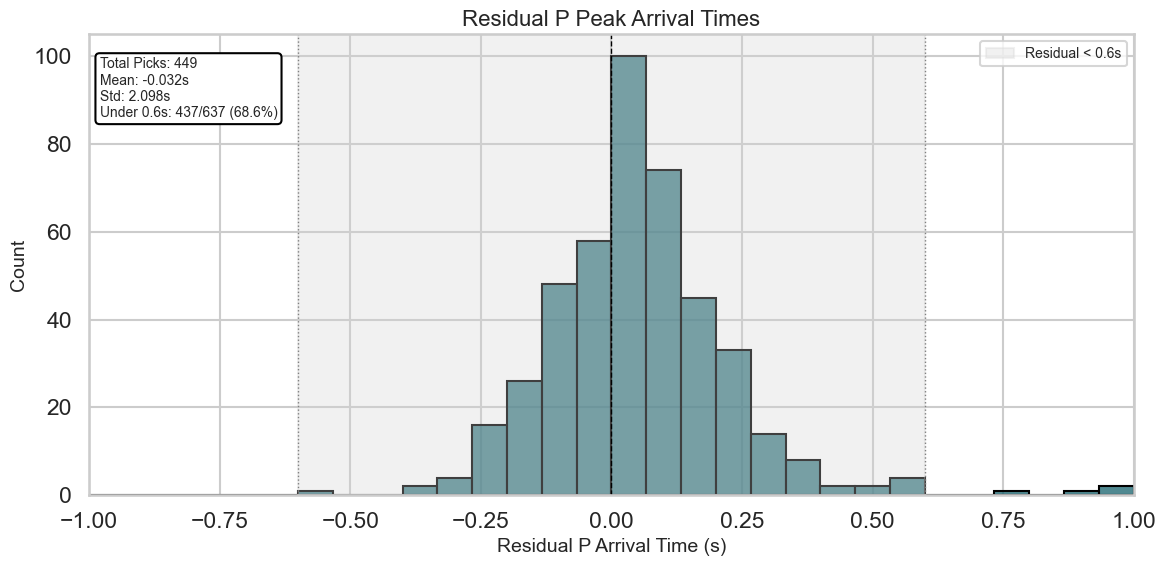

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


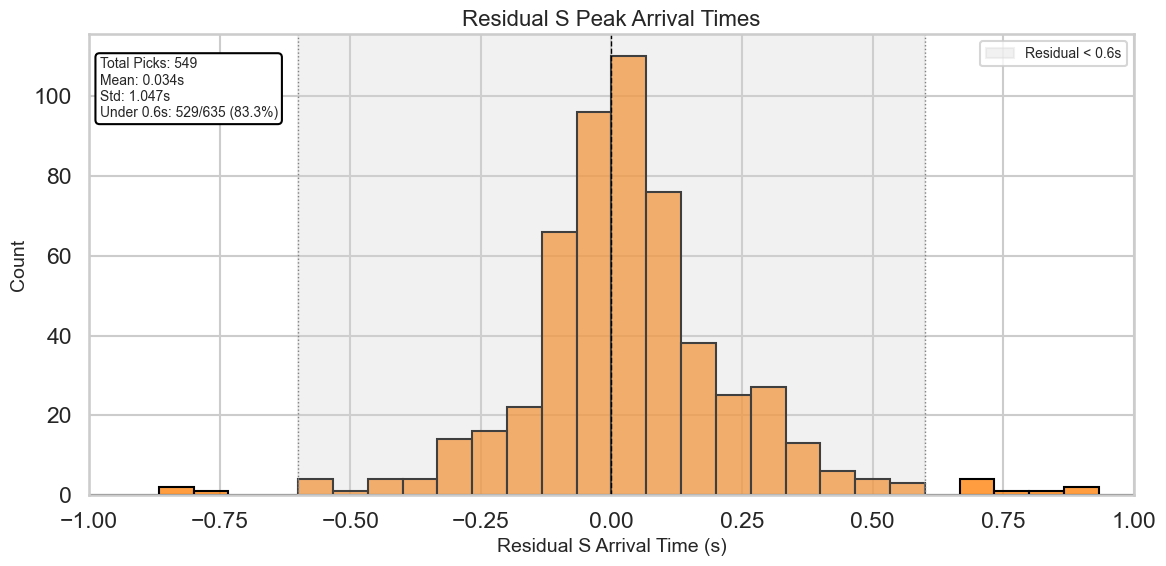

In [87]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Seaborn style
sns.set(style="whitegrid", context="talk")

# Parameters
x_min, x_max = -1, 1
bins = np.linspace(x_min, x_max, 31)  # 30 bins between -1 and 1

# Custom colors
p_color = '#15616d'
s_color = '#ff7d00'
shading_color = '#d3d3d3'  # light gray for shaded success zone

# === P-phase residuals ===
plt.figure(figsize=(12, 6))
sns.histplot(all_residual_p_arrival_times, bins=bins, kde=False, color=p_color, edgecolor='black', stat='count')

# Shaded ±0.6s zone
plt.axvspan(-0.6, 0.6, color=shading_color, alpha=0.3, label='Residual < 0.6s')

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(-0.6, color='gray', linestyle=':', linewidth=1)
plt.axvline(0.6, color='gray', linestyle=':', linewidth=1)

# Stats and annotation
mean_p = np.mean(all_residual_p_arrival_times)
std_p = np.std(all_residual_p_arrival_times)
total_picks_p = len(all_residual_p_arrival_times)
fraction_p = count_residuals_p_under_0_6 / groundtruth_p_peaks

plt.text(x_min + 0.02, plt.gca().get_ylim()[1]*0.95,
         f'Total Picks: {total_picks_p}\nMean: {mean_p:.3f}s\nStd: {std_p:.3f}s\nUnder 0.6s: {count_residuals_p_under_0_6}/{groundtruth_p_peaks} ({fraction_p:.1%})',
         ha='left', va='top', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))

plt.title('Residual P Peak Arrival Times', fontsize=16)
plt.xlabel('Residual P Arrival Time (s)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(x_min, x_max)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("residual_p_histogram_shaded.png")
plt.savefig("residual_p_histogram_shaded.ps")
plt.show()


# === S-phase residuals ===
plt.figure(figsize=(12, 6))
sns.histplot(all_residual_s_arrival_times, bins=bins, kde=False, color=s_color, edgecolor='black', stat='count')

# Shaded ±0.6s zone
plt.axvspan(-0.6, 0.6, color=shading_color, alpha=0.3, label='Residual < 0.6s')

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(-0.6, color='gray', linestyle=':', linewidth=1)
plt.axvline(0.6, color='gray', linestyle=':', linewidth=1)

# Stats and annotation
mean_s = np.mean(all_residual_s_arrival_times)
std_s = np.std(all_residual_s_arrival_times)
total_picks_s = len(all_residual_s_arrival_times)
fraction_s = count_residuals_s_under_0_6 / groundtruth_s_peaks

plt.text(x_min + 0.02, plt.gca().get_ylim()[1]*0.95,
         f'Total Picks: {total_picks_s}\nMean: {mean_s:.3f}s\nStd: {std_s:.3f}s\nUnder 0.6s: {count_residuals_s_under_0_6}/{groundtruth_s_peaks} ({fraction_s:.1%})',
         ha='left', va='top', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))

plt.title('Residual S Peak Arrival Times', fontsize=16)
plt.xlabel('Residual S Arrival Time (s)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(x_min, x_max)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("residual_s_histogram_shaded.png")
plt.savefig("residual_s_histogram_shaded.ps")
plt.show()
